## Master ML Pipeline

### Imports


In [1]:
# Loading the key packages
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sklearn
import hyperopt
from hyperopt import hp
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import sklearn.calibration as cal
import xgboost as xgb
import sklearn.utils.class_weight as wt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from pathlib import Path
from sklearn import datasets, metrics, model_selection, svm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import multiprocessing



In [2]:
from tensorflow.keras import models, layers, utils, backend as K, callbacks
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
#tensorflow.compat.v1.disable_v2_behavior() 
import random
import os

import warnings
#warnings.filterwarnings('ignore')


from numpy.ma import MaskedArray
import sklearn.utils.fixes

import miceforest as mf

sklearn.utils.fixes.MaskedArray = MaskedArray

tf.config.run_functions_eagerly(True)

2025-01-27 09:36:03.052800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging

# Configure the logging module
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [4]:
np.__version__

'1.23.5'

In [5]:
## Rays and tune imports
from tune_sklearn import TuneSearchCV

2025-01-27 09:36:07,548	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-27 09:36:08,031	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
#### USING PYTHON 3.11.0
print(sklearn.__version__)
print(shap.__version__)
print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(xgb.__version__)
print(tf.executing_eagerly())

'''
Should be: 
1.5.2
0.46.0
2.16.2
2.2.2
1.26.4
True
'''

'''
SHOUD BE THE FOLLOWING WITH 3.11.0
1.5.2
0.46.0
2.16.2
2.2.3
1.23.5
2.1.1
setuptools for conda == 41.0.0
True
'''

1.5.2
0.46.0
2.16.2
2.2.3
1.23.5
2.1.1
True


'\nSHOUD BE THE FOLLOWING WITH 3.11.0\n1.5.2\n0.46.0\n2.16.2\n2.2.3\n1.23.5\n2.1.1\nsetuptools for conda == 41.0.0\nTrue\n'

### Setup

In [74]:
# %% Initializing dataframes to store the results


all_results = []


# hyperparam_results = pd.DataFrame(
#     {
#         "Procedure": [],
#         "Outcome": [],
#         "Features": [],
#         "Model": [],
#         "Rep": [],
#         "Hyp_Name": [],
#         "Hyp_Value": []
#     }
# )



feature_results = []

auc_plot_results = []


# Areas which below pipeline will iterate through -- CHANGE THIS BASED ON NEED


#binary_outcomes = np.array(["readmission_binary", "major_med_comp", "extended_los", "returnor", "wnd_related_comp"])
#binary_outcomes = np.array(["readmission_binary"])
#binary_outcomes = np.array(["returnor", "any_med_comp_no_wnd", "any_med_comp_wnd", "any_comp_overall"])
binary_outcomes = ["High_Health_Utilizer"]

#continuous_outcomes = np.array(["outpatient_resource_sum", "los_days"])
#continuous_outcomes = np.array(['los_days'])

continuous_outcomes = []


outcomes = binary_outcomes + continuous_outcomes

#procedures = ["Microdisc", "Foraminotomy", "Laminectomy", "AXDLIF", "PLF", "PTLIF"]
procedures = ["Fusion", "Decompression"]


#features = ["Spine_Institution", "Spine_NSQIP", "Peripheral_NSQIP"]
#features = ["Spine_Institution"]
#features = ["Peripheral_NSQIP"]
#features = ["PLS_features"]
features = ["Health_Util_Features"]
feature = features[0]

model_set = ["RF", "ENet", "XGBoost", "NN", "ASA", "Dummy"]
#model_set = ["RF"]

#model_set = ["XGBoost"]
#model_set = ["Dummy"]



repetitions = list(range(10)) #TODO: Change to range(10)
date = "01_14_25"
impute_iterations = 2 #TODO CHANGE TO 2
tunesearch_iterations = 10 #TODO: Switch to 10
Get_shaps = False #TODO: DO I WANT SHAPS?
procedure_of_interest = "Fusion" #TODO: Change procedure-of-interest
pickle_folder_name = "NoLabs" # Change when doing a different pickling #NoLabs
if procedure_of_interest == "Decompression":
    FullDataset_model = "RF"
elif procedure_of_interest == "Fusion":
    FullDataset_model = "ENet"
else:
    FullDataset_model = None

if procedure_of_interest == "Decompression":
    feature_perturbation_version = "tree_path_dependent" #TODO: For full dataset model RF
elif procedure_of_interest == "Fusion":
    feature_perturbation_version = "NoFeatPert" #TODO: For full dataset model ENet


# Functions

## Setup


In [8]:
def reset_random_seed(rep):
    
    tf.keras.backend.clear_session()

    os.environ['PYTHONHASHSEED']=str(rep)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    tf.random.set_seed(rep)
    np.random.seed(rep)
    random.seed(rep)


In [9]:
def load_data(procedure):
    readdata = pd.read_csv(r"122124_Spine_Reports.csv", sep=',')
    
    if procedure == "Fusion":
        readdata = readdata[
            (readdata['cpt_thoracolumbar_sacro_arthrodesis'] == True) &
            (readdata['cohort_query_lumbar'] == True)
            ]
    elif procedure == "Decompression":
        readdata = readdata[
            (readdata['cpt_thoracolumbar_sacro_arthrodesis'] == False) & 
            (readdata['cohort_query_spinal_decompression'] == True) & 
            (readdata['cohort_query_lumbar'] == True)
        ]


    readdata = readdata.reset_index(drop=True)
    return readdata

In [10]:
def preop_to_binary(input_df):
    df = input_df.copy()
    # Get all columns that start with "preop_med_"
    preop_med_cols = [col for col in df.columns if col.startswith('preop_med_')]
    print(f"There are {len(preop_med_cols)} preop columns")

    # Check for missing values first
    missing_values = {col: df[col].isna().sum() 
                    for col in preop_med_cols 
                    if df[col].isna().any()}

    if missing_values:
        raise ValueError(f"Missing values found in the following columns: {missing_values}")

    # Convert to boolean if no missing values found
    for col in preop_med_cols:
        # Store original values for verification
        original_values = df[col].value_counts()
        
        # Convert: 0 -> False, >=1 -> True
        df[col] = df[col] > 0
        
        # Print verification of the conversion
        print(f"\nColumn: {col}")
        print("Original value counts:")
        print(original_values)
        print("New value counts:")
        print(df[col].value_counts())
    return df

In [11]:
def add_columns_remove_rows(input_df):

    df = input_df.copy()
    # Recode categorical columns
        # anesthesia_type
    df['anesthesia_type_General'] = df['anesthesia_type'].apply(
        lambda x: 1 if pd.notna(x) and str(x).upper() == 'GENERAL'
                  else (0 if pd.notna(x)  # if it's not NaN and not 'GENERAL', return 0
                        else np.nan)  # if it's NaN, return np.nan
    )
    df['anesthesia_type_General'] = df['anesthesia_type_General'].astype('Int64')
    
    #procedure_setting
    df['procedure_setting_Inpatient'] = df['procedure_setting'].apply(lambda x: 1 if str(x).upper() == 'INPATIENT' 
                                            else (0 if str(x).upper() == 'OUTPATIENT' 
                                            else np.nan))
    df['procedure_setting_Inpatient'] = df['procedure_setting_Inpatient'].astype('Int64')
    # Recode gender into new binary column
    df['gender_female'] = df['gender'].apply(lambda x: 1 if str(x).upper() == 'F' 
                                           else (0 if str(x).upper() == 'M' 
                                           else np.nan))
    df['gender_female'] = df['gender_female'].astype('Int64')

    # add allograft and autograft columns
    df['cpt_allograft'] = df['procedure_codes'].str.contains('20930|20931').astype(bool)
    df['cpt_autograft'] = df['procedure_codes'].str.contains('20936|20937|20938').astype(bool)

    # Anterior approach codes
    df['cpt_anterior_approach'] = df['procedure_codes'].str.contains(
        '22556|22558|22586|22808|22810|22812'
    ).astype(bool)

    # Lateral approach codes
    df['cpt_lateral_approach'] = df['procedure_codes'].str.contains(
        '22533|22534'
    ).astype(bool)

    # Posterior approach codes
    df['cpt_posterior_approach'] = df['procedure_codes'].str.contains(
        '22610|22612|22800|22802|22804|22630|22632|22633|22634|27279|27280'
    ).astype(bool)

    # Convert surgery_start_datetime to datetime type if it isn't already
    df['surgery_start_datetime_date'] = pd.to_datetime(df['surgery_start_datetime'])
    df['surgery_end_datetime_date'] = pd.to_datetime(df['surgery_end_datetime'])
    df['patient_in_or_datetime_date'] = pd.to_datetime(df['patient_in_or_datetime'])
    df['patient_out_or_datetime_date'] = pd.to_datetime(df['patient_out_or_datetime'])
    df['anesthesia_start_datetime_date'] = pd.to_datetime(df['anesthesia_start_datetime'])
    df['anesthesia_stop_datetime_date'] = pd.to_datetime(df['anesthesia_stop_datetime'])
    
    # Create date filters
    start_date = pd.to_datetime('2003-01-01')
    end_date = pd.to_datetime('2022-10-01')
    
    df = df[
        # Date conditions
        (df['surgery_start_datetime_date'] >= start_date) & 
        (df['surgery_start_datetime_date'] < end_date) &
        # Age filter - exclude patients under 18
        (df['age_at_procedure'] >= 18) &
        # Previous conditions (negated)
        ~(df['spine_preop_tumor'] | 
          df['spine_preop_trauma'] | 
          df['spine_preop_infection'] |
          df['cpt_tumor'] |
          df['cpt_trauma'] | 
          df['spine_preop_curvature'] |
          df['cpt_deformity']|
          df['cpt_infection'])
    ]



    # Remove neg los patient 1338489,"2012-05-02 09:43:00"
    df = df[~((df['ir_id'] == 1338489) & 
                   (df['surgery_start_datetime'] == "2012-05-02 09:43:00"))]

    df = df.reset_index(drop=True)


    ### Clean BMI: Make NA for >100 and =0
    df.loc[(df['BMI'] > 100) | (df['BMI'] == 0), 'BMI'] = np.nan

    ### Clean Anesthesia: Make NA for >=20
    df.loc[df['anesthesia_duration_hours'] >= 20, 'anesthesia_duration_hours'] = np.nan


    # Make columns in hours and minutes for surgery length
    # Calculate lengths
    df['OR_length_hours'] = ((df['patient_out_or_datetime_date'] - 
                                df['patient_in_or_datetime_date']).dt.total_seconds() / 3600).round()
    df['OR_length_minutes'] = ((df['patient_out_or_datetime_date'] - 
                                    df['patient_in_or_datetime_date']).dt.total_seconds() / 60).round()

    df['anesthesia_length_hours'] = ((df['anesthesia_stop_datetime_date'] - 
                                    df['anesthesia_start_datetime_date']).dt.total_seconds() / 3600).round()
    df['anesthesia_length_minutes'] = ((df['anesthesia_stop_datetime_date'] - 
                                        df['anesthesia_start_datetime_date']).dt.total_seconds() / 60).round()
    
    df['surgery_length_hours'] = ((df['surgery_end_datetime_date'] -
                                    df['surgery_start_datetime_date']).dt.total_seconds() / 3600).round()
    df['surgery_length_minutes'] = ((df['surgery_end_datetime_date'] -
                                    df['surgery_start_datetime_date']).dt.total_seconds() / 60).round()

    # Handle missing values
    OR_missing = df['patient_in_or_datetime_date'].isna() | df['patient_out_or_datetime_date'].isna()
    anesthesia_missing = df['anesthesia_start_datetime_date'].isna() | df['anesthesia_stop_datetime_date'].isna()
    surgery_missing = df['surgery_start_datetime_date'].isna() | df['surgery_end_datetime_date'].isna()

    df.loc[OR_missing, ['OR_length_hours', 'OR_length_minutes']] = np.nan
    df.loc[anesthesia_missing, ['anesthesia_length_hours', 'anesthesia_length_minutes']] = np.nan
    df.loc[surgery_missing, ['surgery_length_hours', 'surgery_length_minutes']] = np.nan

    # Convert to integer type (while preserving NaN values)
    length_columns = ['OR_length_hours', 'OR_length_minutes',
                    'anesthesia_length_hours', 'anesthesia_length_minutes',
                    'surgery_length_hours', 'surgery_length_minutes']
    df[length_columns] = df[length_columns].astype('Int64')  # Int64 allows for NaN values

     ### Clean Anesthesia: Make NA for >=20
    df.loc[df['anesthesia_length_hours'] >= 20, 'anesthesia_length_hours'] = np.nan
    df.loc[df['anesthesia_length_minutes'] >= 20*60, 'anesthesia_length_minutes'] = np.nan

    ### clean surgery: make NA for > 1000 hours or eqivalent minutes
    df.loc[df['surgery_length_hours'] >= 20, 'surgery_length_hours'] = np.nan
    df.loc[df['surgery_length_minutes'] >= 20*60, 'surgery_length_minutes'] = np.nan



    return df
    
    

In [12]:
def remove_labs_90(df):

    input_df = df.copy()

    # Create columns lists for days_before
    CBC_cols = ["CBC_MONOCYTES", "CBC_NEUTROPHILS", "CBC_BASOPHILS", "CBC_PLATELET_COUNT",
                    "CBC_WBC_COUNT", "CBC_HEMOGLOBIN", "CBC_RBC_COUNT",
                    "CBC_RDW", "CBC_HEMATOCRIT", "CBC_MCH", "CBC_MCHC",
                    "CBC_ABSOLUTE_LYMPHOCYTES", "CBC_ABSOLUTE_NEUTROPHILS",
                    "CBC_LYMPHOCYTE", "CBC_EOSINOPHILS", "CBC_ABSOLUTE_EOSINOPHILS",
                    "CBC_ABSOLUTE_BASOPHILS", "CBC_ABSOLUTE_MONOCYTES"]
    
    CBC_date_cols = [col + "_days_before_surgery" for col in CBC_cols]
        
    BMP_cols = ["BMP_POTASSIUM", "BMP_CREATININE", "BMP_BUN", "BMP_CALCIUM", "BMP_CHLORIDE", 
                    "BMP_SODIUM", "BMP_CO2", "BMP_GLUCOSE", "BMP_GFR"]
    BMP_date_cols = [col + "_days_before_surgery" for col in BMP_cols]

    lab_cols = CBC_cols + BMP_cols
    lab_days_before = CBC_date_cols + BMP_date_cols
    lab_pairs = [(lab_cols[i], lab_days_before[i]) for i in range(len(lab_cols))]
    print(lab_pairs)

    def extract_days(x):
        if pd.isna(x):
            return np.nan
        # Extract just the number before "days"
        try:
            return float(str(x).split()[0])
        except:
            return np.nan
    # Process each pair of columns
    for lab_col, days_col in lab_pairs:
        # Convert the days strings to numbers
        days = input_df[days_col].apply(extract_days)

        # Create a mask for values > 90 days
        mask = days > 90
        
        # Set the lab values to NaN where mask is True
        input_df[lab_col] = input_df[lab_col].mask(mask)


    return input_df
    

In [13]:
def set_columns(data, outcome, pofI):
    individual_features_shap_full = []
    # Basic demographics = age, sex, race (not present), BMI
    basic_demographics = ["ir_id", "surgery_start_datetime", "age_at_procedure", "gender_female", "BMI"]

    #Med hx: include all of the comorbidities with the elix_ prefix. 
    # Those are based on the Elixhauser comorbidity guidelines and 
    # are the most comprehensive. We broke out several other frailty
    #  tools (CCI, MFI, etc) but these are ultimately duplicative 
    # and not as comprehensive (i.e. don’t worry about including). 
    # I do not believe elixhauser has anything on tobacco. 
    # If ther isn’t, then use validation_fmr_tobacco and 
    # validation_cur_tobacco.

    Medhx = ["elix_aids_hiv", "elix_lymphoma", "elix_paralysis",
            "elix_psychoses", "elix_depression", "elix_drug_abuse", "elix_weight_loss",
            "elix_coagulopathy", "elix_alcohol_abuse", "elix_liver_disease", "elix_renal_failure",
            "elix_hypothyroidism", "elix_valvular_disease", "elix_blood_loss_anemia",
            "elix_deficiency_anemia", "elix_metastatic_cancer", "elix_cardiac_arrhythmia",
            "elix_rheumatoid_arhritis", "elix_diabetes_complicated", "elix_diabetes_uncomplicated", 
            "elix_congestive_heart_failure", "elix_hypertension_complicated", "elix_chronic_pulmonary_disease",
            "elix_solid_tumor_wo_metastasis", "elix_hypertension_uncomplicated", "elix_other_neurological_disorder",
            "elix_peripheral vascular_disorder", "elix_pulmonary_circulation_disorder", "elix_fluid_and_electrolyte_disorders",
            "elix_peptic_ulcer_disease_excluding_bleeding", "validation_cur_tobacco", "validation_fmr_tobacco"]
    
    #Surg hx: look at the shx_ prefix variables and include those

    Surghx = ["shx_cervical_fusion", "shx_cervical_surgery", "shx_thoracolumbar_fusion",
                "shx_thoracolumbar_surgery", "shx_unspecified_spine_fusion", "shx_unspecified_spine_surgery"]
    
    #Spine-specific preop pathology: lumbar stenosis, lumbar spondy, 
    # lumbar disc disorders, lumbar disc herniation (all binary columns)
    SpineSpecific = ["lumbar_stenosis", "lumbar_spondy", "lumbar_disc_disorders",
                        "cervical_disc_diorders", "cervical_stenosis", "cervical_spondy",
                        "cervical_disc_herniation", "lumbar_disc_herniation", "spine_preop_pseudoarthrosis_post_fusion", "spine_preop_post_laminectomy_syndrome"]

    #Medication hx: look for preop_med_ suffix. Also just focus on 90
    #  days preop for this analysis. Exclude anything with _sorg in the
    #  name (that is for a separate validation analysis)

    Medicationhx = ["preop_med_90days_ace_inhibitor", "preop_med_90days_arb", "preop_med_90days_antidepressant",
                "preop_med_90days_beta_2_agonist", "preop_med_90days_beta_blocker", "preop_med_90days_benzodiazepine",
                "preop_med_90days_immunosuppresant", "preop_med_90days_nsaid", "preop_med_90days_opioid", "preop_med_90days_anti_psychotic",
                "preop_med_90days_neuromodulator", "preop_med_90days_biphosphonate", "preop_med_90days_loop_diuretic",
                "preop_med_90days_thiazide_diuretic", "preop_med_90days_cinacalcet", "preop_med_90days_insulin", 
                "preop_med_90days_oral_diabetes", "preop_med_90days_calcium_supplement", "preop_med_90days_vit_d_supplement"]

    #Surgical characteristics: inpatient versus outpatient, type of anesthesia 
    # (should almost always be general, but a few weird ones here and there), 
    # OR duration, anesthesia duration, cpt_multilevel, cpt_grafts, 
    # cpt_instrumentation (tell us more about what was done during the case)

    SurgCharsNumeric = ["asa_class", "OR_length_minutes",
                        "cpt_multilevel", "cpt_instrumentation", 
                        "cohort_query_microdisc", "anesthesia_type_General", "procedure_setting_Inpatient"]
    
    Approaches = ["cpt_anterior_approach", "cpt_lateral_approach", "cpt_posterior_approach"]

    #Add approach columns if Fusion
    if pofI == "Fusion":
        SurgCharsNumeric = SurgCharsNumeric + Approaches

    #SurgCharsCat = ["anesthesia_type", "procedure_setting"]

    # CBC and BMP, all with <50% missing values

    CBC_cols = ["CBC_MONOCYTES", "CBC_NEUTROPHILS", "CBC_BASOPHILS", "CBC_PLATELET_COUNT",
                "CBC_WBC_COUNT", "CBC_HEMOGLOBIN", "CBC_RBC_COUNT",
                "CBC_RDW", "CBC_HEMATOCRIT", "CBC_MCH", "CBC_MCHC",
                "CBC_ABSOLUTE_LYMPHOCYTES", "CBC_ABSOLUTE_NEUTROPHILS",
                "CBC_LYMPHOCYTE", "CBC_EOSINOPHILS", "CBC_ABSOLUTE_EOSINOPHILS",
                "CBC_ABSOLUTE_BASOPHILS", "CBC_ABSOLUTE_MONOCYTES"]
    
    BMP_cols = ["BMP_POTASSIUM", "BMP_CREATININE", "BMP_BUN", "BMP_CALCIUM", "BMP_CHLORIDE", 
                "BMP_SODIUM", "BMP_CO2", "BMP_GLUCOSE", "BMP_GFR"]
    
    
    

    outcome = [outcome]
    ## Set Lab columns
    labCols = BMP_cols + CBC_cols
    if pickle_folder_name == "NoLabs":
        all_columns = basic_demographics + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "Labs":
        all_columns = basic_demographics + BMP_cols + CBC_cols + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "Testing":
        all_columns = basic_demographics + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "TestingLabs":
        all_columns = basic_demographics + BMP_cols + CBC_cols + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome

    df = data[all_columns].copy()

    ## Fix ASA class
    df['asa_class'] = df['asa_class'].replace(0, np.nan)

    
    #df['asa_above_2'] = np.where(df['asa_class'] >= 3, 1, 0)
    

    #dum_cols = ["anesthesia_type", "procedure_setting"]

    numeric_features = ["age_at_procedure", "BMI", "OR_length_minutes"]
    
        # Convert preop columns to boolean
    preop_columns = [col for col in df.columns if col.startswith('preop')]
    print(f"{len(preop_columns)} Preop Columns")

    
    for col in preop_columns:
        trueBefore = sum(df[col] == True)
        df[col] = df[col].astype('boolean')
        # df[col] = df[col].astype('float')
        df[col] = df[col].astype('Int64') # Just convert to Int64
        # df[col] = df[col].fillna(0) #fill na as 0 in binary conversion
        trueAfter = sum(df[col] == True)
        if trueBefore != trueAfter:
            raise ValueError(f"""
            Column {col} has different number of True values after conversion!
            Before: {trueBefore} True values
            After: {trueAfter} True values
            Difference: {trueAfter - trueBefore}
            """)
        else: 
            print("All preop conversions good!")
    

    ## Change these float columns to ints

    to_int_cols = ["age_at_procedure", 'OR_length_minutes']

    for col in to_int_cols:
        df[col] = df[col].astype("Int64")

    
    ## ADD Lab columns to numeric_features
    if pickle_folder_name in ["Labs", "TestingLabs"]:
        numeric_features = numeric_features + labCols
        print("adding lab columns to numeric_features") 
        for col in labCols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Ensure the column dtype is float
            df[col] = df[col].astype('float')
    
    #Convert "object" columns to categorical (NO CATEGORICAL COLUMNS NOW)
    '''
    objectcols = SurgCharsCat
    for col in objectcols:
        df[col] = df[col].astype('category')
    '''

    # Create ASA df
    df_asa = df[['ir_id', 'surgery_start_datetime', 'asa_class', outcome[0]]].copy()
    df_asa['asa_class'] = df_asa['asa_class'].astype("Int64")

    #remove ASA from df
    df = df.drop('asa_class', axis=1)
    
        
    return df, df_asa, numeric_features, individual_features_shap_full

In [14]:
## Create new dfs for predictors, preds+dummies, and ys

def separate_dfs(df, outcome):
    """
    Separates a dataframe into three separate dataframes: predictors, dummies, and ys.

    Args:
        df (pandas.DataFrame): The input dataframe.
        dum_cols (list): A list of column names that are dummy variables. NO MORE DUM COLUMNS

    Returns:
        tuple: A tuple containing three dataframes: (df_preds, dum_df, y).
    """
    #df = df.dropna().reset_index(drop=True) # drop missing variables
    
    y = df[outcome].values

    df_preds = df.drop(columns = [outcome])

    #dum_df = pd.get_dummies(df_preds, columns= dum_cols)

    return df_preds, y

In [15]:
# Function for feature + outcome combo NOT USED YET
'''
def full_feature_outcome_test(feature, outcome):
   
   Function to do the entire test for a feature + outcome combo
   Inputs: feature (string), outcome (string)
   
   n = len(df)
   label_n = sum(y)
   return 

'''

'\ndef full_feature_outcome_test(feature, outcome):\n   \n   Function to do the entire test for a feature + outcome combo\n   Inputs: feature (string), outcome (string)\n   \n   n = len(df)\n   label_n = sum(y)\n   return \n\n'

## Functions to be repeated



In [16]:
### Formulating the preprocessor for scaling and stratified folds

def scaleAnd_skf(numeric_features, outcome, rep, fulldataset = False):
     # Formulating the preprocessor for scaling
    scaler = preprocessing.RobustScaler()

    if fulldataset:
        preprocessor = ColumnTransformer([('robust', scaler, numeric_features)], remainder = 'passthrough', verbose_feature_names_out=False)
    else:
        preprocessor = ColumnTransformer([('minmax', scaler, numeric_features)], remainder = 'passthrough')

    if outcome in binary_outcomes:
        
        skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = rep) #TODO: Change back to 5

    elif outcome in continuous_outcomes:
        
        print("In Progress")
    
    return preprocessor, skf

### To do within each traintest split

In [17]:
## Save the dtypes for the xtrain_std and x_test_std

def save_dtypes(df, original_df, preprocessor):
    feature_names = preprocessor.get_feature_names_out()
    df = pd.DataFrame(df, columns=feature_names, index=original_df.index)
    df.columns = [col.replace('minmax__', '') for col in df.columns]
    df.columns = [col.replace('remainder__', '') for col in df.columns]
    for col in df.columns:
        if col in original_df.columns:
            #print("Good")
            #print(col)

            #df[col] = df[col].astype(original_df[col].dtype)
            df[col] = df[col].astype('float64')

        else:
            print("ERROR")
            #print(col)
    return df
    

In [18]:
## Any extra missing values filled in using mode/median of same dataset

def post_imputation_cleanup(data):
    total_replaced = 0
    for col in data.columns:
        if data[col].isnull().any():
            nan_count_before = data[col].isnull().sum()
            if data[col].dtype.name == 'category':
                # For categorical data, use mode if it exists
                if not data[col].mode().empty:
                    data[col].fillna(data[col].mode()[0], inplace=True)
            elif data[col].dtype.kind in 'biufc':  # boolean, integer, unsigned integer, float, complex
                # For numeric data, use median if it exists and is not null
                median = data[col].median()
                if pd.notnull(median):
                    data[col].fillna(median, inplace=True)
            else:
                # For other types (like object), use mode if it exists
                if not data[col].mode().empty:
                    data[col].fillna(data[col].mode()[0], inplace=True)
            
            nan_count_after = data[col].isnull().sum()
            replaced = nan_count_before - nan_count_after
            total_replaced += replaced

            print(f"Column '{col}': {replaced} NaN values replaced")

            
            # Check if there are still NaN values after imputation
            if data[col].isnull().any():
                print(f"Warning: Column '{col}' still contains NaN values after imputation.")
    
    return data

In [19]:
def imputeData(x_train, y_train, x_test, y_test, rep, impute_number):
    # Combine x_train and y_train for imputation
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)

    train_data = x_train.copy()
    train_data['target'] = y_train

    # Create and fit the imputation kernel
    
    kernel = mf.ImputationKernel(
        train_data,
        random_state=rep,
        variable_schema = NaNColumn_list
    )
    
    # Use sklearn pipeline method (as in examples)
    pipe = Pipeline([('impute', kernel)])
    
    # Perform imputation
    #kernel.mice(impute_number, verbose=True)  # Run 5 iterations, adjust as needed
    
    # Get the imputed training data
    #imputed_train = kernel.complete_data()

    imputed_train = pipe.fit_transform(train_data, impute__iterations = impute_number,
                                       impute__verbose=True)
    
    #imputed_train = post_imputation_cleanup(imputed_train)

    assert not np.any(np.isnan(imputed_train))

    # Separate features and target
    x_train_imputed = imputed_train.drop('target', axis=1)
    y_train_imputed = imputed_train['target']

    # Combine Test data
    test_data = x_test.copy()
    #test_data['target'] = y_test
    test_data['target'] = np.nan 
    test_data['target'] = test_data['target'].astype('bool')# add dummy target column
    # Impute test data
    test_imputed = pipe.transform(test_data)
    #test_imputed = kernel.transform(test_data)
    #test_imputed = post_imputation_cleanup(test_imputed)
    x_test_imputed = test_imputed.drop('target', axis=1)

    assert not np.any(np.isnan(x_test_imputed))

    y_test_imputed = y_test

    
    return x_train_imputed, y_train_imputed, x_test_imputed, y_test_imputed


In [20]:
#### Create training, test, validation sets and additional sets
def set_train_test(input_df, y, train_index, test_index, rep, preprocessor, impute_number,
                   want_val = False):
    # Split into train and test

    # NEED TO HAVE DUMMYS HERE AFTER IMPUTATION! do in impute_data

    # dum_df cut out asa_class column
    # x_train_asa = asa_class.iloc[train_index].copy()
    # x_test_asa = asa_class.iloc[test_index].copy()
    # add these two to the output of set_train_test
        
    x_train_split = input_df.iloc[train_index].copy()
    x_test_split = input_df.iloc[test_index].copy()
    y_train_split = y[train_index].copy()
    y_test_split = y[test_index].copy()
    
    
    # Peel off validation set

    x_train_actual_split, x_val_split, y_train_actual_split, y_val_split = train_test_split(x_train_split,
                                                                                            y_train_split, stratify = y_train_split,
                                                                                            test_size = 0.1, random_state = rep) # random process


    # Remove mrn and surgery start datetime and include that as the actual train and test
        
        
    #if feature == mainfeature:
        
    print("Test")

    if want_val:

        x_train_actual = x_train_actual_split.drop(columns = ["ir_id", "surgery_start_datetime"])
        x_val = x_val_split.drop(columns = ["ir_id", "surgery_start_datetime"])
        y_train_actual = y_train_actual_split.copy()
        y_val = y_val_split.copy()

        # IMPUTED VALUES
        x_train_actual, y_train_actual, x_val, y_val = imputeData(x_train_actual, y_train_actual, x_val, y_val, rep, impute_number)
    else:
        x_train_actual = None
        x_val = None
        y_train_actual = None
        y_val = None



    x_train = x_train_split.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_test = x_test_split.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_test_id_cols = x_test_split[["ir_id", "surgery_start_datetime"]]
    x_test_id_cols = x_test_id_cols.reset_index(drop=True)
    y_train = y_train_split.copy()
    y_test = y_test_split.copy()

    #IMPUTED VALUES
    x_train, y_train, x_test, y_test = imputeData(x_train, y_train, x_test, y_test, rep, impute_number)
    
    
    x_train_std = preprocessor.fit_transform(x_train)
    x_train_std = save_dtypes(x_train_std, x_train, preprocessor)
    x_test_std = preprocessor.transform(x_test)
    x_test_std = save_dtypes(x_test_std, x_test, preprocessor)



    # Keep a version that has those values as index columns 

    x_test_features = x_test.copy() #use imputed data
    # Add back the identifier columns
    x_test_features = pd.concat([x_test_id_cols, x_test_features], axis=1)

    x_test_features["Patient_ID"]=  np.arange(len(x_test_features))

    x_test_features_long = pd.melt(x_test_features, id_vars = ["ir_id", "Patient_ID", "surgery_start_datetime"], var_name = "Feature_Name", value_name = "Feature_Actual_Value" )
    
    x_test_features_long['Feature_Actual_Value'] = pd.to_numeric(x_test_features_long['Feature_Actual_Value'])

    x_cols = x_test.columns

    n_features = len(x_cols)
    
    return x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, x_test_features_long, n_features, x_cols, x_train_std, x_test_std

### All the different Models

In [21]:
## ASA model - only works for binary outcomes

def ASA_model(x_train, x_test, y_train, rep):

    '''
    Input: x_train: training data from train-test set
           x_test: test data from train-test set
           y_train: training labels from train-test set
           rep: random state for reproducibility

    Output: cv_model: trained logistic regression model
            y_pred: predicted labels for test set
            y_prob_vec: predicted probabilities for test set
    '''

    # Extract ASA class feature
    trim_train = x_train[["asa_class"]].copy()
    trim_test = x_test[["asa_class"]].copy()

    # Fit logistic regression model
    cv_model = linear_model.LogisticRegression(penalty=None, random_state=rep)
    cv_model.fit(trim_train, y_train)

    # Make predictions
    y_pred = cv_model.predict(trim_test)
    y_prob = cv_model.predict_proba(trim_test)
    y_prob_vec = y_prob[:, 1]

    return cv_model, y_pred, y_prob_vec

In [22]:
## ASA Categorical model -> <=2 and >2
def ASA_categorical_model(x_test):
    
    x_test['asa_above_2'] = np.where(x_test['asa_class'] >= 3, 1, 0)

    trim_test_categorical = x_test["asa_above_2"]


    y_pred = trim_test_categorical.values.reshape(-1,1)
    y_prob = trim_test_categorical.values.reshape(-1,1)
    y_prob_vec = trim_test_categorical.values.reshape(-1,1)
    #print(y_prob_vec)
    return y_pred, y_prob_vec

In [23]:
def ENet_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): column_name of outcome variable
            preprocessor (obj): standardizing preprocessing object
            x_train (df): training data from train-test set
            y_train (df): training outcome variable from train-test set
            x_test (df): test data from train-test set
            x_train_std (df): standardized training data
            x_test_std (df): standardized test data

    Outputs: cv_model (obj): best model from bayesian optimization
             y_pred (arr): predicted values for test set
             y_prob_vec (arr): predicted probability values for test set
             shap_values (arr): shap values for test set
    '''
    if outcome in binary_outcomes:
        '''
        y_train_df = pd.DataFrame(y_train, columns = ["y_train"])
        All_train = pd.concat([x_train, y_train_df], axis = 1)

        kernel = mf.ImputationKernel(
            All_train,
            random_state=rep,
            variable_schema = NaNColumn_list
        )
        '''
        pipe = Pipeline([   #('impute', kernel),
                            ('processing', preprocessor), 
                            ('estimator', linear_model.LogisticRegression(penalty = 'elasticnet', 
                                                                        solver='saga', 
                                                                        class_weight = 'balanced',
                                                                        random_state = rep, 
                                                                        max_iter = 1000
                                                                        ))])

        fit_params = {'impute__iterations': impute_iterations,
                      'impute__verbose': True}
        model_params = {'estimator__C': Real(1e-2, 1e2, prior = 'log-uniform'),
                        'estimator__l1_ratio': Real(0, 1)
                        }
        hyperopt_model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
            'estimator__l1_ratio': hp.uniform('estimator__l1_ratio', 0, 1)
                                 }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = hyperopt_model_params, 
                                search_optimization="hyperopt",
                                verbose = 2,
                                scoring='roc_auc', # auc is most important metric
                                refit=True,
                                cv=5,
                                n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep
                                )

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.predict_proba(x_test)
        y_prob_vec = y_prob[:,1]


    elif outcome in continuous_outcomes:

        print("In Progress")


    if Get_shaps:
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_std)
        shap_values = explainer.shap_values(x_test_std)
        print("SHAPS DONE")
    else:
        shap_values = None
        print("NO SHAPS FOOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [24]:
def XGBoost_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:

        weight_vec = wt.compute_sample_weight(class_weight = "balanced", y = y_train) # compute weights using sklearn
#        eval_weight = wt.compute_sample_weight(class_weight = "balanced", y = y_val)

        pipe = Pipeline([('processing', preprocessor), 
                            ('estimator', xgb.XGBClassifier(#n_estimators = 500,
                                                            #eval_metric = "auc",
                                                            use_label_encoder=False,
                                                            verbosity = 1, random_state = rep
                                                        ))]) 


        es = xgb.callback.EarlyStopping(
            rounds = 10,
            save_best=True,
        )
        print(f"XShape: {x_train.shape}")

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 2, 10),
            'estimator__subsample': hp.uniform('estimator__subsample', 0.5, 1.0),
            'estimator__learning_rate': hp.uniform('estimator__learning_rate', 0.1, 0.5),
            'estimator__colsample_bytree': hp.uniform('estimator__colsample_bytree', 0.5, 1.0),
            'estimator__colsample_bylevel': hp.uniform('estimator__colsample_bylevel', 0.5, 1.0),
            'estimator__min_child_weight': hp.uniformint('estimator__min_child_weight', 1, 10),
            'estimator__gamma': hp.uniform('estimator__gamma', 0, 1.0),
            'estimator__reg_lambda': hp.loguniform('estimator__reg_lambda', np.log(1e-2), np.log(1e2)),
            'estimator__reg_alpha': hp.loguniform('estimator__reg_alpha', np.log(1e-2), np.log(1e2)),
        }

        fit_params = {#'estimator__sample_weight_eval_set': [eval_weight],
#                                          'estimator__eval_set': [(x_val_std, y_val)],
#                                          'estimator__callbacks': [es],
                        'estimator__sample_weight': weight_vec,
#                                          'estimator__early_stopping_rounds': 10

        }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', 
                                refit=True, cv= 5, 
                                n_jobs = 7, random_state = rep, 
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train, **fit_params)



        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.predict_proba(x_test) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        print("In Progress")



    if Get_shaps:
        explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], data=x_train_std, model_output = "probability")
        shap_values = explainer.shap_values(x_test_std)
        print(shap_values.shape)
        test = shap_values[0] # TODO: Check if 0 is correct here if needed
        print(test.shape)
        print("SHAPS DONE")
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values

In [25]:
def RF_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep, n_features_in, Interventional):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:

        pipe = Pipeline([('processing', preprocessor), 
                            ('estimator', BalancedRandomForestClassifier(random_state = rep,
                                                                         sampling_strategy='all',
                                                                         replacement=True,
                                                                         bootstrap=False
                                                                         ))]) 

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_features': hp.uniformint('estimator__max_features', 2, n_features_in),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 1, 25),
            'estimator__min_samples_split': hp.uniformint('estimator__min_samples_split', 2, 10),
            'estimator__min_samples_leaf': hp.uniformint('estimator__min_samples_leaf', 1, 5),
        }

        cv_model = TuneSearchCV(pipe,
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', # AUC is most important metric
                                refit=True, cv=5, n_jobs = 7,
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_test) # generate prediction (0 or 1)
        y_prob = cv_model.predict_proba(x_test) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        print("In Progress")

    if Get_shaps:
        if Interventional:
            print("DOING INTERVENTIONAL")
            explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], data=x_train_std, feature_perturbation= "interventional",
                                       model_output = "probability")
        else:
            print("DOING PATH DEPENDENT")
            explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], feature_perturbation= "tree_path_dependent")
        shap_values = explainer.shap_values(x_test_std)
        print(shap_values.shape)
        shap_values = shap_values[:, :, 1]
        print(shap_values.shape)
        print("GET SHAPS")
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [26]:
def Dummy_model(outcome, x_train, y_train, x_test):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''
    if outcome in binary_outcomes:

        dummy_clf = DummyClassifier(strategy="prior")
        dummy_clf.fit(x_train, y_train)

        y_pred = dummy_clf.predict(x_test)
        y_prob = dummy_clf.predict_proba(x_test)
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        dummy_clf = DummyRegressor(strategy="median")
        dummy_clf.fit(x_train, y_train)

        y_pred = np.round(dummy_clf.predict(x_test))

    return dummy_clf, y_pred, y_prob_vec


In [27]:
def NN_model(outcome, preprocessor, x_train_actual, y_train_actual, x_val, y_val, x_test, n_features, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    #tf.config.run_functions_eagerly(True)

    if outcome in binary_outcomes:

        x_train_actual_std = preprocessor.fit_transform(x_train_actual)
        x_train_actual_std = save_dtypes(x_train_actual_std, x_train_actual, preprocessor)
        x_val_std = preprocessor.transform(x_val)
        x_val_std = save_dtypes(x_val_std, x_val, preprocessor)

#       x_train_std = preprocessor.fit_transform(x_train)
        x_test_std = preprocessor.transform(x_test)
        x_test_std = save_dtypes(x_test_std, x_test, preprocessor)

        reset_random_seed(rep)


        metric_set=[tf.keras.metrics.AUC(name="auc")]



        weight_vec = wt.compute_sample_weight(class_weight = "balanced", y = y_train_actual) # compute weights using sklearn
        eval_weight = wt.compute_sample_weight(class_weight = "balanced", y = y_val)


        # Convert data to TensorFlow datasets
        #train_dataset = tf.data.Dataset.from_tensor_slices((x_train_actual_std, y_train_actual, weight_vec))
        #train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

        #val_dataset = tf.data.Dataset.from_tensor_slices((x_val_std, y_val, eval_weight))
        #val_dataset = val_dataset.batch(32)


        nn_model = tf.keras.Sequential(name="DeepNN_CLF", layers=[

            # Input layer is implicitly defined here

            ### hidden layer 1
            tf.keras.layers.Dense(name="h1", input_dim=n_features,
                            units=int(round((n_features+1)/2)), 
                            activation='relu'),

            ### dropout layer 1
            tf.keras.layers.Dropout(name="drop1", rate=0.2, seed = rep),

            ### hidden layer 2
            tf.keras.layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                            activation='relu'),

            ### dropout layer 2
            tf.keras.layers.Dropout(name="drop2", rate=0.2, seed = rep),

            ### layer output
            tf.keras.layers.Dense(name="output", units=1, activation='sigmoid')
        ])

        nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = metric_set)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_auc', 
            verbose=1,
            patience=10,
            mode='max',
            restore_best_weights=True)

        history = nn_model.fit(
            x_train_actual_std,
            y_train_actual,
            epochs= 100, #TODO: Change back to 100
            sample_weight=weight_vec,
            batch_size=32, #added
            callbacks=[early_stopping],
            validation_data=(x_val_std, y_val, eval_weight),
        )

        y_prob = nn_model.predict(x_test_std) 
        y_pred = (y_prob > 0.5).astype("int32")                 
        y_prob_vec = y_prob.flatten()

        nn_model.summary()

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.tight_layout()
        plt.show()


    elif outcome in continuous_outcomes:

        print("In Progress")


    # SHAP values calculation
    '''
    tf.config.run_functions_eagerly(False)
    print(tf.executing_eagerly())
    background = shap.sample(x_train_actual_std, 100)  # Use a subset of training data as background
    explainer = shap.DeepExplainer(nn_model, background)
    shap_values = explainer.shap_values(x_test_std.values)
    shap_values = shap_values[:, :, 0]
    print(shap_values.shape)
    tf.config.run_functions_eagerly(True)
    '''
    
    
    #explainer = shap.DeepExplainer(nn_model, data=x_train_actual_std)
    #print(type(x_test_std))
    #shap_values = explainer.shap_values(x_test_std)
    #print(shap_values.shape)

    return nn_model, y_pred, y_prob_vec


In [28]:

def Linear_SVC_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            x_train_std (pd.DataFrame): standardized training data
            x_test_std (pd.DataFrame): standardized test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:


        pipe = Pipeline([('processing', preprocessor),
                         ('estimator', sklearn.svm.LinearSVC(random_state=rep,
                                                             dual=False,
                                                             max_iter=1000,
                                                             class_weight='balanced' ))])

        model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
        }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = model_params, 
                                scoring='roc_auc', # auc is most important metric
                                refit=True, 
                                cv=5, n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2
                                )        
        
        cv_model.fit(x_train, y_train)

        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.decision_function(x_test)
        y_prob_vec = 1 / (1 + np.exp(-y_prob))

    elif outcome in continuous_outcomes:
        print("In Progress")

    if Get_shaps:
        print("GET SHAPS")
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_std)
        shap_values = explainer.shap_values(x_test_std)
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [29]:
from sklearn.kernel_approximation import Nystroem


def SVC_model_with_kernels(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            x_train_std (pd.DataFrame): standardized training data
            x_test_std (pd.DataFrame): standardized test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:
        pipe = Pipeline([
            ('processing', preprocessor),
            ('nystroem', Nystroem(random_state=rep)),
            ('estimator', LinearSVC(random_state=rep, dual=False, max_iter=1000, class_weight='balanced'))
        ])

        model_params = {
            'nystroem__kernel': hp.choice('nystroem__kernel', ['rbf', 'poly', 'sigmoid']),
            'nystroem__n_components': hp.uniformint('nystroem__n_components', 50, 200),
            'nystroem__gamma': hp.loguniform('nystroem__gamma', np.log(1e-3), np.log(1e1)),
            'nystroem__degree': hp.uniformint('nystroem__degree', 2, 6),  # Integer values from 2 to 5
            'nystroem__coef0': hp.uniform('nystroem__coef0', 0, 1),  # Uniform distribution between 0 and 1
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
        }
        '''
        # Define separate search spaces for each kernel
        linear_params = {}  # No additional parameters for linear kernel
        rbf_params = {
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
        }
        poly_params = {
            'nystroem__degree': Integer(2, 5),
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
            'nystroem__coef0': Real(0, 1),
        }
        sigmoid_params = {
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
            'nystroem__coef0': Real(0, 1),
        }

        # Combine the search spaces based on the kernel
        search_spaces = model_params.copy()
        search_spaces.update(linear_params if 'linear' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(rbf_params if 'rbf' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(poly_params if 'poly' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(sigmoid_params if 'sigmoid' in search_spaces['nystroem__kernel'] else {})
        '''
        
        cv_model = TuneSearchCV(
            pipe, 
            param_distributions=model_params, 
            scoring='roc_auc',
            refit=True, 
            cv=5,
            n_jobs=7,
            n_trials=tunesearch_iterations,  # Increased due to larger search space
            random_state=rep,
            search_optimization = "hyperopt",
            verbose = 2
        )        
        
        cv_model.fit(x_train, y_train)
        best_params = cv_model.best_params_
        best_kernel = best_params['nystroem__kernel']
        #best_gamma = best_params['nystroem__gamma']
        print(f"Best kernel: {best_kernel}")
        #print(f"Best gamma: {best_gamma}")

        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.decision_function(x_test)
        y_prob_vec = 1 / (1 + np.exp(-y_prob))

    elif outcome in continuous_outcomes:
        print("In Progress")
        return

    # Transform the data using the fitted Nystroem approximation
    nystroem = cv_model.best_estimator_.named_steps['nystroem']
    x_train_nystroem = nystroem.transform(x_train_std)
    x_test_nystroem = nystroem.transform(x_test_std)
    print(type(nystroem.components_))
    print(nystroem.components_.shape)

    if Get_shaps:
        print("GET SHAPS")
        #For SHAP values, we'll use KernelExplainer as LinearExplainer won't work with the kernel approximation
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_nystroem)
        shap_values = explainer.shap_values(x_test_nystroem)
        print(shap_values.shape)
    else:
        print("NO SHAPS FOR YOU")
        shap_values = None

    return cv_model, y_pred, y_prob_vec, shap_values, best_kernel


In [30]:
print(shap.__version__)

0.46.0


## Function for Results

In [31]:
from datetime import datetime
import math

def log_execution(csv_path, name_of_model, start_time):
    end_time = time.time()
    total_seconds = end_time - start_time
    
    # Calculate minutes and seconds
    minutes = math.floor(total_seconds / 60)  # Get complete minutes
    seconds = round(total_seconds % 60)  # Get remaining seconds, rounded
    
    # Create new row
    new_row = {
        'model_name': name_of_model,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'execution_time_minutes': minutes,
        'execution_time_seconds': seconds
    }
    
    # Read existing CSV, append new row, and save
    try:
        df = pd.read_csv(csv_path)
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    except FileNotFoundError:
        # If file doesn't exist, create new DataFrame
        df = pd.DataFrame([new_row])
    
    df.to_csv(csv_path, index=False)


In [32]:
def collect_results(results_list, auc_plot_list, outcome, procedure, feature, model_name, rep, i, n, label_n, y_test, y_prob_vec, y_pred):
    """
    Collects and computes performance metrics for binary classification models.

    This function calculates various performance metrics for binary classification models and stores them in a results dataframe.
    It also generates ROC curve data for plotting.

    Parameters:
        results_list (list): List to store performance metric results
        auc_plot_list (list): List to store ROC curve plotting data
        outcome (str): Name of the outcome being predicted
        procedure (str): Name of the procedure being analyzed
        feature (str): Name/description of features used
        model_name (str): Name of the model used
        rep (int): Repetition number
        i (int): Fold number for cross-validation
        n (int): Total number of samples
        label_n (int): Number of labeled samples
        y_test (array-like): True labels
        y_prob_vec (array-like): Predicted probabilities
        y_pred (array-like): Predicted labels

    Returns:
        None - Updates results_list and auc_plot_list in place

    Metrics calculated:
    - AUC (Area Under ROC Curve)
    - Sensitivity/Recall
    - Specificity
    - PPV (Positive Predictive Value)
    - NPV (Negative Predictive Value) 
    - Log Loss
    - Brier Score
    - Weighted F1 Score
    - Accuracy
    - Balanced Accuracy
    - Confusion Matrix

    The function only processes binary classification outcomes (checks if outcome is in binary_outcomes).
    Results are stored in a pandas DataFrame and appended to the input lists.
    """

    if outcome in binary_outcomes:
        # Computing AUC
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob_vec, pos_label = 1)
        roc_auc = metrics.auc(fpr, tpr)
        AUC = metrics.auc(fpr, tpr)

        print(f"AUC: {AUC}")
        logging.info(f"AUC, Logging: {AUC}")
        # Sensitivity, Specificity

        recall_score_0 = metrics.recall_score(y_test,y_pred, pos_label=0)
        recall_score_1 = metrics.recall_score(y_test,y_pred, pos_label=1)

        # PPV, NPV
        precision_score_0 = metrics.precision_score(y_test,y_pred, pos_label=0)
        precision_score_1 = metrics.precision_score(y_test,y_pred, pos_label=1)

        # Computing Log Loss
        log_loss = metrics.log_loss(y_test, y_prob_vec, labels = [0,1])

        # Computing Brier score
        brier_loss = metrics.brier_score_loss(y_test, y_prob_vec, pos_label = 1)

        # Computing WF1
        W_F1= metrics.f1_score(y_test, y_pred, average='weighted')

        # Computing Accuracy
        accuracy_score = metrics.accuracy_score(y_test,y_pred)
        B_accuracy_score = metrics.balanced_accuracy_score(y_test,y_pred)


        # Confusion Matrix
        c_mat = metrics.confusion_matrix(y_test, y_pred)

        new_results = pd.DataFrame(
            {
                "Procedure": [procedure],
                "Outcome": [outcome],
                "Features": [feature],
                "Model": [model_name],
                "Rep": [rep],
                "Fold": [i],
                "W_F1": [W_F1],
                "AUC": [AUC],
                "MAE": ["NA"],
                "R2": ["NA"],
                "RMSE": ["NA"],
                "Log-Loss": [log_loss],
                "Brier-Loss": [brier_loss],
                "Accuracy": [accuracy_score],
                "Balanced_Accuracy": [B_accuracy_score],
                "Sensitivity": [recall_score_1],
                "Specificity": [recall_score_0],
                "NPV": [precision_score_0],
                "PPV": [precision_score_1],
                "c_matrix": [c_mat],
                "n":[n],
                "label_n": [label_n]
            }
        )

        auc_plot_results_new = pd.DataFrame(
            {
                "Procedure": np.repeat(procedure, len(fpr)),
                "Outcome": np.repeat(outcome, len(fpr)),
                "Features": np.repeat(feature, len(fpr)),
                "Model": np.repeat(model_name, len(fpr)),
                "Rep": np.repeat(rep, len(fpr)),
                "Fold": np.repeat(i, len(fpr)),
                "FPR": fpr,
                "TPR": tpr,
                "Thresholds": threshold
            }
        )
        #print(len(fpr))
        auc_plot_list.append(auc_plot_results_new)

        results_list.append(new_results)

    return


In [33]:
def collect_shap_results(individual_features_shap_full_list, feature_results_list, shap_values, y_test, x_cols, x_test_features_long, outcome, procedure,
                         feature, model_name, rep, i, svcKernel = False):
    
    '''
    Inputs: individual_features_shap_full: empty shap list

    Outputs: shap_file_results: dataframe of shap values for each patient and feature
    '''
    mod_shap = shap_values.copy()
    #mod_shap = shap_values[0]

    test_length = len(y_test)

    row_vec = list(range(0, test_length))
    shap_features_row = []
    if svcKernel:
        print(x_cols)
    for row in row_vec:

        shap_values_row = mod_shap[row]

        temp_feature_names = list(x_cols) #CHECK here
        



        new_shap_features_row = pd.DataFrame(
            {
                "Patient_ID": np.repeat(row, len(x_cols)),
                "Feature_Name": temp_feature_names,
                "Feature_Value": shap_values_row,
                "Feature_Abs_Value": np.abs(shap_values_row),

            }
        )

        shap_features_row.append(new_shap_features_row)




    shap_features_tabular = pd.concat(shap_features_row)



    individual_features_shap = x_test_features_long.merge(shap_features_tabular, how = "left", on = ["Patient_ID", "Feature_Name"])

    individual_features_shap["Procedure"]=  procedure
    individual_features_shap["Outcome"]=  outcome
    individual_features_shap["Model"]=  model_name
    individual_features_shap["Rep"]=  rep
    individual_features_shap["Fold"]=  i


    individual_features_shap_full_list.append(individual_features_shap)

    summarized_features_shap = shap_features_tabular.groupby(['Feature_Name']).agg(   
        Feature_Mean_Abs = ('Feature_Abs_Value','mean'),
    ).reset_index()


    feature_coef = summarized_features_shap['Feature_Mean_Abs'].values
    feature_names = summarized_features_shap['Feature_Name'].values


    new_features = pd.DataFrame(
        {
            "Procedure": np.repeat(procedure, len(feature_names)),
            "Outcome": np.repeat(outcome, len(feature_names)),
            "Features": np.repeat(feature, len(feature_names)),
            "Model": np.repeat(model_name, len(feature_names)),
            "Rep": np.repeat(rep, len(feature_names)),
            "Fold": np.repeat(i, len(feature_names)),
            "Feature_Name": feature_names,
            "Feature_Mean_Abs_Value": feature_coef,

        }
    )


#                    feature_results = feature_results.append(new_features, ignore_index=True)
    feature_results_list.append(new_features)


    return

In [34]:
#pip install shap==0.41.0 --user
print(shap.__version__)


0.46.0


# Code

## Code Setup

In [35]:
# Load data 
## TEST WITH FUSION FIRST

print(procedure_of_interest)
data_non_binary = load_data(procedure_of_interest)
#data = pd.read_csv(r"081524_Spine_reports_vf.csv", sep=',')

Fusion


/var/folders/92/tt9zk05n4qd65slhpygj9v4r0000gr/T/ipykernel_64257/3567218305.py:2: DtypeWarning: Columns (73,74,75,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,455,456,460,462,464,466,468,470,471,474,476,478,480,481,482,490,492,493,494,495,496,497,498,499,500,502,504,506,508,510,511,512,516,518,520,522,523,524,526,528,529,531,532,534,537,538,539,540,541,542,544,545,546,547,548,550,551,552,553,554,555,557,560,561,562,563,564,566,568,570,571,574,575,576,577,583,585,586,587,588,589,590,591,592,593,596,600,601,605,606,607,609,610,612,613,614,616,618,619,620,622,624,625,626,628,629,634,635,636,637,638,642,643,646,650,652,653,654,658,660,662,664,666,668,671,673,675,677,679,681,682,683,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,708,709,710,711,714,716,717,719,720,722,725,728,729,732,736,737,740,743,744,746,747,750,751,754,766,767,768,769,772,773,782,783,784,785,786,787,788,789,792,793,794,795,796,797,814,815,822,823,830,831,83

In [36]:
outcomes

['High_Health_Utilizer']

In [37]:
##Convert to binary preop_meds
data = preop_to_binary(data_non_binary)

There are 66 preop columns

Column: preop_med_90days_ace_inhibitor
Original value counts:
preop_med_90days_ace_inhibitor
0    4286
1     432
2      25
3       1
Name: count, dtype: int64
New value counts:
preop_med_90days_ace_inhibitor
False    4286
True      458
Name: count, dtype: int64

Column: preop_med_90days_arb
Original value counts:
preop_med_90days_arb
0    4307
1     405
2      32
Name: count, dtype: int64
New value counts:
preop_med_90days_arb
False    4307
True      437
Name: count, dtype: int64

Column: preop_med_90days_antidepressant
Original value counts:
preop_med_90days_antidepressant
0    3757
1     852
2     127
3       8
Name: count, dtype: int64
New value counts:
preop_med_90days_antidepressant
False    3757
True      987
Name: count, dtype: int64

Column: preop_med_90days_beta_2_agonist
Original value counts:
preop_med_90days_beta_2_agonist
0    3864
1     609
2     207
3      51
4      12
5       1
Name: count, dtype: int64
New value counts:
preop_med_90days_beta

In [38]:

file_name_base = procedure_of_interest+"_"+date+"_"
file_name_base

'Fusion_01_14_25_'

In [39]:
#full_feature_outcome_test(feature="PLS_features", outcome="Post_lam_syndrome")
data.shape

(4744, 985)

In [40]:
sum(data['gender'] == 'U')

0

In [41]:
### Set up what columns to use 
## Testing with fusion first
# Set feature, outcome
mainfeature = "Health_Util_Features"
outcome = outcomes[0]
print(outcome)
data_new = add_columns_remove_rows(data)
print(data_new.shape)

High_Health_Utilizer
(2890, 1005)


In [42]:
# BMP missing columns

bmp_columns = [col for col in data_new.columns if col.startswith('BMP')]
# Calculate the percentage of missing values for each of these columns
missing_percentages = data_new[bmp_columns].isnull().mean() * 100

# Convert the result to a DataFrame for better readability
BMP_missing_df = pd.DataFrame({'Column': missing_percentages.index, 'Percent Missing': missing_percentages.values})
BMP_missing_df.to_csv(f"{procedure_of_interest}_{pickle_folder_name}_BMP_missing.csv", index=False)

# CBC missing columns

cbc_columns = [col for col in data_new.columns if col.startswith('CBC')]
# Calculate the percentage of missing values for each of these columns
missing_percentages = data_new[cbc_columns].isnull().mean() * 100

# Convert the result to a DataFrame for better readability
CBC_missing_df = pd.DataFrame({'Column': missing_percentages.index, 'Percent Missing': missing_percentages.values})
CBC_missing_df.to_csv(f"{procedure_of_interest}_{pickle_folder_name}_CBC_missing.csv", index=False)


In [43]:
# Remove Labs
data_null_labs = remove_labs_90(data_new)
print(data_null_labs.shape)


[('CBC_MONOCYTES', 'CBC_MONOCYTES_days_before_surgery'), ('CBC_NEUTROPHILS', 'CBC_NEUTROPHILS_days_before_surgery'), ('CBC_BASOPHILS', 'CBC_BASOPHILS_days_before_surgery'), ('CBC_PLATELET_COUNT', 'CBC_PLATELET_COUNT_days_before_surgery'), ('CBC_WBC_COUNT', 'CBC_WBC_COUNT_days_before_surgery'), ('CBC_HEMOGLOBIN', 'CBC_HEMOGLOBIN_days_before_surgery'), ('CBC_RBC_COUNT', 'CBC_RBC_COUNT_days_before_surgery'), ('CBC_RDW', 'CBC_RDW_days_before_surgery'), ('CBC_HEMATOCRIT', 'CBC_HEMATOCRIT_days_before_surgery'), ('CBC_MCH', 'CBC_MCH_days_before_surgery'), ('CBC_MCHC', 'CBC_MCHC_days_before_surgery'), ('CBC_ABSOLUTE_LYMPHOCYTES', 'CBC_ABSOLUTE_LYMPHOCYTES_days_before_surgery'), ('CBC_ABSOLUTE_NEUTROPHILS', 'CBC_ABSOLUTE_NEUTROPHILS_days_before_surgery'), ('CBC_LYMPHOCYTE', 'CBC_LYMPHOCYTE_days_before_surgery'), ('CBC_EOSINOPHILS', 'CBC_EOSINOPHILS_days_before_surgery'), ('CBC_ABSOLUTE_EOSINOPHILS', 'CBC_ABSOLUTE_EOSINOPHILS_days_before_surgery'), ('CBC_ABSOLUTE_BASOPHILS', 'CBC_ABSOLUTE_BASOPH

In [44]:
## Create outcome variable
data_w_outcome = data_null_labs.copy()

data_w_outcome['specialist_visits'] = data_w_outcome['Number_of_neurosurgery_visits'] + data_w_outcome['Number_of_orthopaedic_visits']
data_w_outcome['emergency_visits'] = data_w_outcome['Number_of_ED'] + data_w_outcome['Number_of_urgent_care_visits']
data_w_outcome['Number_pain_meds'] = data_w_outcome['Number_of_opioids_prescriptions'] + data_w_outcome['Number_of_benzodiazepine_prescriptions'] + data_w_outcome['Number_of_neuromodulator_prescriptions']
data_w_outcome['Number_referrals'] = data_w_outcome['Number_of_PT_referrals'] + data_w_outcome['Number_of_other_referrals'] 

count_columns = ['specialist_visits', 'emergency_visits', 'Number_of_imaging_orders', 'Number_pain_meds', 'Number_referrals']


for column in count_columns:
    p75 = data_w_outcome[column].quantile(0.75)
    print(f"{column}: {p75}")

percentiles = data_w_outcome[count_columns].quantile(0.75)
data_w_outcome['High_physician_time'] = ((data_w_outcome['specialist_visits'] > percentiles['specialist_visits']) | 
                                            (data_w_outcome['Number_referrals'] > percentiles['Number_referrals'])).astype('Int64')
data_w_outcome['High_medication_time'] = ((data_w_outcome['emergency_visits'] >= 1) | 
                                               (data_w_outcome['Number_pain_meds'] > percentiles['Number_pain_meds']) |
                                               (data_w_outcome['Number_of_imaging_orders'] > percentiles['Number_of_imaging_orders'])).astype('Int64')


# Convert to DataFrame (makes it easier to save to CSV)
count_stats = []
for col in count_columns:
    col_type = data_w_outcome[col].dtype
    missing = data_w_outcome[col].isna().sum()
    total = len(data_w_outcome[col])
    
    # Create stats dictionary for each column
    col_stats = {
        'column': col,
        'dtype': str(col_type),
        'missing_count': missing,
        'missing_pct': (missing/total * 100).round(2),
        'mean': data_w_outcome[col].mean(),
        'std': data_w_outcome[col].std(),
        'min': data_w_outcome[col].min(),
        '25%': data_w_outcome[col].quantile(0.25),
        'median': data_w_outcome[col].median(),
        '75%': data_w_outcome[col].quantile(0.75),
        'max': data_w_outcome[col].max()
    }
    count_stats.append(col_stats)

extra_cols = ['High_physician_time', 'High_medication_time']

for col in extra_cols:
    col_type = data_w_outcome[col].dtype
    missing = data_w_outcome[col].isna().sum()
    total = len(data_w_outcome[col])

    # Handle both boolean and binary integer columns
    non_null = total - missing
    true_count = data_w_outcome[col].sum()
    false_count = non_null - true_count
    
    col_stats = {
        'column': col,
        'dtype': str(col_type),
        'missing_count': missing,
        'missing_pct': (missing/total * 100).round(2),
        'true_count': true_count,
        'true_pct': (true_count/non_null * 100).round(2) if non_null > 0 else 0,
        'false_count': false_count,
        'false_pct': (false_count/non_null * 100).round(2) if non_null > 0 else 0
    }
    count_stats.append(col_stats)

# Convert to DataFrame
count_summary_df = pd.DataFrame(count_stats)

# Save to CSV
count_summary_df.to_csv(f'{procedure_of_interest}_{pickle_folder_name}_percentile_75_thresholds.csv', index=False)

''' OR
# Create the classification
# If threshold or more counts are above their 75th percentile -> high utilizer (1)
# Otherwise -> low/normal utilizer (0)
def classify_utilizer(row, threshold=2):  # Added threshold parameter
    count_above_75 = 0  # Counter for columns exceeding 75th percentile
    for column in count_columns:
        if row[column] > percentiles[column]:
            count_above_75 += 1
    return 1 if count_above_75 >= threshold else 0  # Return 1 if meets or exceeds threshold
'''
# Create the classification
# If ALL counts are above their 75th percentiles -> high utilizer (1)
# If ANY count is below its 75th percentile -> low/normal utilizer (0)
''' AND
def classify_utilizer(row):
    for column in count_columns:
        if row[column] <= percentiles[column]:  # Changed > to <= and flipped the logic
            return 0  # Low/normal utilizer
    return 1  # High utilizer - only reached if ALL counts are above 75th percentile
'''

# Apply the classification with threshold of 2
threshold = 1  # You can adjust this number as needed
#data_w_outcome['High_Health_Utilizer'] = data_w_outcome.apply(lambda x: classify_utilizer(x, threshold=threshold), axis=1)
#data_w_outcome['High_Health_Utilizer'] = data_w_outcome.apply(classify_utilizer, axis=1)
data_w_outcome['High_Health_Utilizer'] = ((data_w_outcome['High_physician_time'] == 1) &
                                          (data_w_outcome['High_medication_time'] == 1)).astype("Int64")
data_w_outcome['High_Health_Utilizer'] = data_w_outcome['High_Health_Utilizer'].astype('bool')

specialist_visits: 3.0
emergency_visits: 0.0
Number_of_imaging_orders: 6.0
Number_pain_meds: 10.0
Number_referrals: 2.0


In [45]:
df, df_asa, numeric_features, individual_features_shap_full = set_columns(data=data_w_outcome, outcome=outcome,
                                                                          pofI= procedure_of_interest)


19 Preop Columns
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!


In [46]:
column_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes    
})
print(df.shape)


(2890, 82)


In [47]:
print(numeric_features)


['age_at_procedure', 'BMI', 'OR_length_minutes']


In [48]:
### Separate df into three new dfs using separate_dfs
# original dum_df shape (with dropnan): 11709, 102

df_preds, y = separate_dfs(df, outcome=outcome)
n = len(df_preds)
label_n = sum(y)
df_preds.shape

#Fusion shape (3581, 81)

(2890, 81)

In [49]:
## Get a list of all columns with nan values
nan_df = df_preds.isna()
NaNColumn_list = nan_df.any().loc[nan_df.any() == True].index.tolist()
print(len(NaNColumn_list))
print(NaNColumn_list)

3
['BMI', 'anesthesia_type_General', 'procedure_setting_Inpatient']


In [50]:
# Get summary stats
df_for_summary = df.copy()
df_for_summary['surgery_start_datetime'] = pd.to_datetime(df_for_summary['surgery_start_datetime'])
(df_for_summary.dtypes).unique()

def get_summary_stats(df):
    # Initialize lists to store results
    stats = []
    nrow, ncol = df.shape
    shape_stats = {
        'column': 'DataFrame Shape',
        'dtype': 'info',
        'missing_count': nrow,
        'missing_pct': ncol
    }
    stats.append(shape_stats)

    for col in df.columns:
        col_type = df[col].dtype
        missing = df[col].isna().sum()
        total = len(df[col])
        
        # Create base stats dictionary
        col_stats = {
            'column': col,
            'dtype': str(col_type),
            'missing_count': missing,
            'missing_pct': (missing/total * 100).round(2)
        }
        # Check if Int64/int64 column is binary (0,1,NA only)
        is_binary = False
        if col_type in ['Int64']:
            unique_vals = df[col].dropna().unique()
            is_binary = set(unique_vals).issubset({0, 1})

        # Add type-specific statistics
        if (col_type in ['int64', 'Int64', 'float64']) and not is_binary:
            col_stats.update({
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                '25%': df[col].quantile(0.25),
                'median': df[col].median(),
                '75%': df[col].quantile(0.75),
                'max': df[col].max()
            })
        elif col_type == 'datetime64[ns]':
             # For datetime, calculate days from the minimum date
            min_date = df[col].min()
            days_from_min = (df[col] - min_date).dt.total_seconds() / (24*60*60)
            
            col_stats.update({
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': days_from_min.std(),  # Standard deviation in days
                '25%': df[col].quantile(0.25),
                'median': df[col].quantile(0.50),
                '75%': df[col].quantile(0.75),
                'range_days': (df[col].max() - df[col].min()).days
            })
        elif col_type == 'bool' or is_binary:
            # Handle both boolean and binary integer columns
            non_null = total - missing
            true_count = df[col].sum()
            false_count = non_null - true_count
            
            col_stats.update({
                'true_count': true_count,
                'true_pct': (true_count/non_null * 100).round(2) if non_null > 0 else 0,
                'false_count': false_count,
                'false_pct': (false_count/non_null * 100).round(2) if non_null > 0 else 0
            })
        stats.append(col_stats)
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(stats)
    return summary_df

# Use the function
summary_stats = get_summary_stats(df_for_summary)

summary_stats.to_csv(f'{procedure_of_interest}_{pickle_folder_name}_summary_stats.csv', index=True)


In [51]:
# Setup cell
csv_path = f'{procedure_of_interest}_{pickle_folder_name}_{date}_model_execution_log.csv'
if not os.path.exists(csv_path):
    pd.DataFrame(columns=['model_name', 'timestamp', 
                        'execution_time_minutes', 'execution_time_seconds']).to_csv(csv_path, index=False)

In [52]:
'''
#Negative LOS patients
df_LOS_neg = df_for_summary[df_for_summary['LOS_days'] < 0]
df_LOS_neg.to_csv('df_LOS_neg.csv', index=True)
'''

"\n#Negative LOS patients\ndf_LOS_neg = df_for_summary[df_for_summary['LOS_days'] < 0]\ndf_LOS_neg.to_csv('df_LOS_neg.csv', index=True)\n"

In [53]:
'''
#Where graft is true
df_graft_true = data[data['cpt_graft'] == True]
# Split the strings and get unique values
unique_numbers = set()

# Assuming your column name is 'column_name' - replace with actual column name
for string in df_graft_true['procedure_codes'].dropna():  # dropna() to handle any NaN values
    numbers = string.split('; ')  # split on '; '
    unique_numbers.update(numbers)

# Convert to sorted list for better viewing
unique_numbers_sorted = sorted(unique_numbers)

print("Unique numbers found:")
print(unique_numbers_sorted)
print(f"\nTotal unique numbers: {len(unique_numbers_sorted)}")
'''


'\n#Where graft is true\ndf_graft_true = data[data[\'cpt_graft\'] == True]\n# Split the strings and get unique values\nunique_numbers = set()\n\n# Assuming your column name is \'column_name\' - replace with actual column name\nfor string in df_graft_true[\'procedure_codes\'].dropna():  # dropna() to handle any NaN values\n    numbers = string.split(\'; \')  # split on \'; \'\n    unique_numbers.update(numbers)\n\n# Convert to sorted list for better viewing\nunique_numbers_sorted = sorted(unique_numbers)\n\nprint("Unique numbers found:")\nprint(unique_numbers_sorted)\nprint(f"\nTotal unique numbers: {len(unique_numbers_sorted)}")\n'

In [54]:
### plot out number of missing by surgery year
import matplotlib.pyplot as plt
import os
import seaborn as sns
want_missingcharts = False
if want_missingcharts:

    # Create directory if it doesn't exist
    output_dir = f'preop_missing_{procedure_of_interest}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract year from datetime column
    df_for_summary['surgery_year'] = df_for_summary['surgery_start_datetime'].dt.year

    # Get all preop columns
    preop_columns = [col for col in df_for_summary.columns if col.startswith('preop')]

    # Create a plot for each preop column
    for col in preop_columns:
        plt.figure(figsize=(10, 6))
        
        # Calculate missing values by year
        missing_by_year = df_for_summary.groupby('surgery_year')[col].apply(lambda x: x.isna().sum()).reset_index()
        missing_by_year.columns = ['Year', 'Missing Count']
        
        # Create bar plot
        sns.barplot(data=missing_by_year, x='Year', y='Missing Count')
        
        # Customize plot
        plt.title(f'Missing Values by Year: {col}')
        plt.xlabel('Surgery Year')
        plt.ylabel('Number of Missing Values')
        plt.xticks(rotation=45)
        
        # Add value labels on top of bars
        for i, v in enumerate(missing_by_year['Missing Count']):
            plt.text(i, v, str(v), ha='center', va='bottom')
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{col}_missing.png')
        plt.close()

    # Optional: Create a summary plot with all preop columns
    plt.figure(figsize=(12, 8))

    # Melt the data for all preop columns
    melted_df_for_summary = df_for_summary.melt(id_vars=['surgery_year'], 
                        value_vars=preop_columns, 
                        var_name='Preop Variable', 
                        value_name='Value')

    # Calculate missing values
    missing_summary = (melted_df_for_summary.groupby(['surgery_year', 'Preop Variable'])
                    .apply(lambda x: x['Value'].isna().sum())
                    .reset_index(name='Missing Count'))

    # Create summary plot
    sns.barplot(data=missing_summary, 
                x='surgery_year', 
                y='Missing Count', 
                hue='Preop Variable')

    plt.title('Missing Values by Year: All Preop Variables')
    plt.xlabel('Surgery Year')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_preop_missing.png')
    plt.close()



## Model Fitting and Results DFs

In [55]:
print(model_set)
print(n)
print(procedure_of_interest)
print(label_n)
print(df_preds.shape)


['RF', 'ENet', 'XGBoost', 'NN', 'ASA', 'Dummy']
2890
Fusion
451
(2890, 81)


In [56]:
# Later, when you need to use the data for a specific model:
def load_split_data(rep, fold):
    print(f'Loading split data for {pickle_folder_name}, {procedure_of_interest}, rep {rep} and fold {fold}')
    with open(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits/split_data_rep{rep}_fold{fold}.pkl', 'rb') as f:
        return pickle.load(f)


### Save TrainTests

In [ ]:
import pickle
# Create a directory to store the pickled data
traintest_start_time = time.time()
os.makedirs(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits', exist_ok=True)
for rep in repetitions:
    preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
    for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
        
        # Create all the different train_test splits
        print(f'Creating train_test split for {pickle_folder_name}, procedure {procedure_of_interest}, rep {rep} fold {i}')
        split_data = set_train_test(input_df= df_preds, y=y, train_index=train_index, test_index=test_index, rep=rep, preprocessor=preprocessor,
                                    impute_number=impute_iterations, want_val=True)
        with open(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits/split_data_rep{rep}_fold{i}.pkl', 'wb') as f:
            pickle.dump(split_data, f)

log_execution(csv_path, 'TrainTestSplit', traintest_start_time)

### ASA

In [ ]:
## ASA
'''
def ASA_train_test(procedure):

    # Create results lists
    ASA_results_list = []
    ASA_auc_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            ASA_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            
            
         
            asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)
            collect_results(ASA_results_list, ASA_auc_list, outcome, procedure, feature, "ASA", rep, i, n, label_n,
                                                            y_test, y_prob_vec, y_pred)

    ASA_results = pd.concat(ASA_results_list, ignore_index=True)
    ASA_auc_results = pd.concat(ASA_auc_list, ignore_index=True)

    return ASA_results, ASA_auc_results
'''

In [59]:
#NEW ASA USING LOGISTIC REGRESSION!
def ASA_train_test(procedure):

    # Create results lists
    ASA_results_list = []
    ASA_auc_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_asa, y)):
            # Create all the different train_test splits

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            X_train_asa = df_asa.iloc[train_index].copy()
            X_train_asa = X_train_asa.reset_index(drop=True)
            X_test_asa = df_asa.iloc[test_index].copy()
            X_test_asa = X_test_asa.reset_index(drop=True)
            y_train = y[train_index].copy()
            y_test = y[test_index].copy()


            # Impute ASA class with mode of training set
            train_mode = X_train_asa['asa_class'].mode()[0]
            X_train_asa['asa_class'] = X_train_asa['asa_class'].fillna(train_mode)
            X_test_asa['asa_class'] = X_test_asa['asa_class'].fillna(train_mode)

            # Extract features and reshape for sklearn
            X_train = X_train_asa['asa_class'].values.reshape(-1, 1)
            X_test = X_test_asa['asa_class'].values.reshape(-1, 1)

            # No need to scale since it's a single ordinal variable
            # Train logistic regression
            lr_model = LogisticRegression(random_state=rep)
            lr_model.fit(X_train, y_train)
            
            # Get predictions
            y_pred = lr_model.predict(X_test)
            y_prob_vec = lr_model.predict_proba(X_test)[:, 1]
            
            
            collect_results(ASA_results_list, ASA_auc_list, outcome, procedure, feature, "ASA", rep, i, n, label_n,
                                                            y_test, y_prob_vec, y_pred)

    ASA_results = pd.concat(ASA_results_list, ignore_index=True)
    ASA_auc_results = pd.concat(ASA_auc_list, ignore_index=True)

    return ASA_results, ASA_auc_results


#### Run ASA


In [ ]:
ASA_start_time = time.time()
ASA_results, ASA_auc_results = ASA_train_test(procedure_of_interest)
log_execution(csv_path, "ASA", ASA_start_time)

In [61]:
ASA_auc_results.to_csv(procedure_of_interest+ "_" + pickle_folder_name + "_ASA_" + "auc_data.csv")
ASA_results.to_csv(procedure_of_interest+"_" + pickle_folder_name + "_ASA_"+ "model_results.csv")

### ASA Categorical

In [ ]:
## ASA categorical
'''
def ASA_categorical_train(procedure):
    asa_cat_results_list = []
    asa_cat_auc_list = []
    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            ASA_cat_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_cat_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            y_pred, y_prob_vec_two = ASA_categorical_model(x_test)
            #print(y_prob_vec_two)
            collect_results(asa_cat_results_list, asa_cat_auc_list, outcome, procedure, feature,
                            "ASA_Categorical", rep, i, n, label_n, y_test, y_prob_vec_two, y_pred)

    ASA_cat_results = pd.concat(asa_cat_results_list, ignore_index=True)
    ASA_cat_auc_results = pd.concat(asa_cat_auc_list, ignore_index=True)

    return ASA_cat_results, ASA_cat_auc_results
'''

#### Run ASA Categorical

In [ ]:
'''
ASA_cat_results, ASA_cat_auc_results = ASA_categorical_train(procedure_of_interest)
ASA_cat_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_" + "auc_data.csv")
ASA_cat_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_"+ "model_results.csv")
'''

### ENet

In [66]:
## ENet

import numpy as np
def ENet_model_train_test(procedure):

    ENet_results_list = []
    ENet_auc_list = []
    ENet_shap_full_list = []
    ENet_shap_summary_list = []

    for rep in repetitions:
        #rep = 4
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            #if i != 3: 
            #    continue
            # Create all the different train_test splits
            Enet_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = Enet_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            print(f"SizeData {x_train.shape}")
            #x_train = x_train.reset_index(drop=True)

            ENet_model_fitted, y_pred, y_prob_vec, shap_values = ENet_model(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(ENet_results_list, ENet_auc_list, outcome, procedure, feature,
                            "ENet", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(ENet_shap_full_list, ENet_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure, feature, "ENet",
                                    rep, i)
            else:
                print("Not collecting shaps")
            
            ENET_temp_results = pd.concat(ENet_results_list, ignore_index=True)
            ENET_temp_auc_results = pd.concat(ENet_auc_list, ignore_index=True)
            
            ENET_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_ENET_" + "auc_data.csv")
            ENET_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                ENET_temp_shap_long_results = pd.concat(ENet_shap_full_list, ignore_index=True)
                ENET_temp_shap_summary_results = pd.concat(ENet_shap_summary_list, ignore_index=True)
                ENET_temp_shap_long_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+"feature_importance_full.csv")
                ENET_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+"feature_importance.csv")
            else:
                print("Not saving temp Shaps")
            
            

    ENet_results = pd.concat(ENet_results_list, ignore_index=True)
    ENet_auc_results = pd.concat(ENet_auc_list, ignore_index=True)
    if Get_shaps:
        print("Saving final shaps")
        ENet_shap_long_results = pd.concat(ENet_shap_full_list, ignore_index=True)
        ENet_shap_summary_results = pd.concat(ENet_shap_summary_list, ignore_index=True)
    else:
        print("Not saving final shaps")
        ENet_shap_long_results = None
        ENet_shap_summary_results = None

    return ENet_results, ENet_auc_results, ENet_shap_long_results, ENet_shap_summary_results, shap_values


#### Enet Run

In [ ]:
# Get results, AUC results, shaps, and shap summaries
import time
ENet_start_time = time.time()
ENet_results, ENet_auc_results, ENet_shap_long_results, ENet_shap_summary_results, shap_values_Enet = ENet_model_train_test(procedure_of_interest)
log_execution(csv_path, 'ENet', ENet_start_time)

#### Enet Save

In [68]:
ENet_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_" + "auc_data.csv")
ENet_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Saving Shap vals to CSV")
    ENet_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+"feature_importance.csv")
    ENet_shap_long_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+"feature_importance_full.csv")
else:
    print("Not saving Shap vals to CSV")

### XGBoost

In [70]:
## XGBoost
def XGB_model_train_test(procedure):
    XGB_results_list = []
    XGB_auc_list = []
    XGB_shap_full_list = []
    XGB_shap_summary_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            XGBoost_model_fitted, y_pred, y_prob_vec, shap_values_two = XGBoost_model(outcome, preprocessor, x_train,
                                                                                y_train, x_test, x_train_std, x_test_std,
                                                                                rep)
            collect_results(XGB_results_list, XGB_auc_list, outcome, procedure, feature, "XGB", rep, i, n,
                            label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(XGB_shap_full_list, XGB_shap_summary_list, shap_values_two, y_test,
                                 x_cols, x_test_features_long, outcome, procedure, feature, 
                                 "XGB", rep, i)
            else:
                print("Not collecting shaps")
            
            XGB_temp_results = pd.concat(XGB_results_list, ignore_index=True)
            XGB_temp_auc_results = pd.concat(XGB_auc_list, ignore_index=True)
            XGB_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_XGB_" + "auc_data.csv")
            XGB_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+ "model_results.csv")


            if Get_shaps:
                print("Saving temp shaps")
                XGB_temp_shap_full_results = pd.concat(XGB_shap_full_list, ignore_index=True)
                XGB_temp_shap_summary_results = pd.concat(XGB_shap_summary_list, ignore_index=True)
                XGB_temp_shap_full_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance_full.csv")
                XGB_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance.csv")
            else:
                print("Not saving temp shaps")


    XGB_results = pd.concat(XGB_results_list, ignore_index=True)
    XGB_auc_results = pd.concat(XGB_auc_list, ignore_index=True)

    if Get_shaps:
        print("Saving final shaps")
        XGB_shap_full_results = pd.concat(XGB_shap_full_list, ignore_index=True)
        XGB_shap_summary_results = pd.concat(XGB_shap_summary_list, ignore_index=True)
    else:
        print("Not Saving Final shaps")
        XGB_shap_full_results = None
        XGB_shap_summary_results = None

    return XGB_results, XGB_auc_results, XGB_shap_full_results, XGB_shap_summary_results

#### XGB run

In [ ]:
XGB_start_time = time.time()
XGB_results, XGB_auc_results, XGB_shap_full_results, XGB_shap_summary_results = XGB_model_train_test(procedure_of_interest)
log_execution(csv_path, 'XGB', XGB_start_time)

#### XBG Save

In [72]:
XGB_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_" + "auc_data.csv")
XGB_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Saving shap csv")
    XGB_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance.csv")
    XGB_shap_full_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance_full.csv")
else:
    print("Not saving shap csv")

In [ ]:
print(XGB_shap_summary_results)



### RF

In [75]:
## RF
Get_shaps = True
InterventionalBool = False
def RF_model_train_test(procedure):
    RF_results_list = []
    RF_auc_list = []
    RF_shap_full_list = []
    RF_shap_summary_list = []

    for rep in repetitions:
       # if rep != 1:
        #    continue
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
         #   if i != 1:
          #      continue
            RF_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = RF_split_data

            print(f"XShape {x_train.shape}")
            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            RF_model_fitted, y_pred, y_prob_vec, shap_values = RF_model(outcome, preprocessor, x_train,
                                                                        y_train, x_test, x_train_std, x_test_std,
                                                                        rep, n_features, InterventionalBool)
            
            collect_results(RF_results_list, RF_auc_list, outcome, procedure, feature, "RF", rep, i,
                            n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collect Shaps")
                collect_shap_results(RF_shap_full_list, RF_shap_summary_list, shap_values, y_test, 
                                    x_cols, x_test_features_long, outcome, procedure, feature, "RF", rep,
                                    i)
            else:
                print("Not collecting Shaps")
            
            RF_temp_results = pd.concat(RF_results_list, ignore_index=True)
            RF_temp_auc_results = pd.concat(RF_auc_list, ignore_index=True)
            RF_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_RF_" + "auc_data.csv")
            RF_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                RF_temp_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
                RF_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
                RF_temp_shap_full_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "feature_importance_full.csv")
                RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance.csv")
            else:
                print("Not Saving Temp Shaps")

    RF_results = pd.concat(RF_results_list, ignore_index=True)
    RF_auc_results = pd.concat(RF_auc_list, ignore_index=True)

    if Get_shaps:
        print("Save full shaps")
        RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
        RF_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
    else:
        print("Not saving full shaps")
        RF_shap_full_results = None
        RF_shap_summary_results = None

    return RF_results, RF_auc_results, RF_shap_full_results, RF_shap_summary_results

#### RF Run

In [ ]:
RF_start_time = time.time()
RF_results, RF_auc_results, RF_shap_full_results, RF_shap_summary_results = RF_model_train_test(procedure_of_interest)
log_execution(csv_path, 'RF', RF_start_time)

#### RF Save

In [77]:
RF_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_" + "auc_data.csv")
RF_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Save shaps to csv")
    RF_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance.csv")
    RF_shap_full_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance_full.csv")
else:
    print("Not saving shaps to csv")

Get_shaps = False

### Dummy

In [79]:
## Dummy

def Dummy_model_train_test(procedure):
    Dummy_results_list = []
    Dummy_auc_list = []
    for rep in repetitions:
        #rep = 1
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            #if i != 2:
            #    continue
            # Create all the different train_test splits

            Dummy_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = Dummy_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            Dummy_model_fitted, y_pred, y_prob_vec = Dummy_model(outcome, x_train, y_train, x_test)
            collect_results(Dummy_results_list, Dummy_auc_list, outcome, procedure, feature, "Dummy", rep, i, n, 
                            label_n, y_test, y_prob_vec, y_pred)
    
    Dummy_results = pd.concat(Dummy_results_list, ignore_index=True)
    Dummy_auc_results = pd.concat(Dummy_auc_list, ignore_index=True) 

    return Dummy_results, Dummy_auc_results
            

In [ ]:
Dummy_start_time = time.time()
Dummy_results, Dummy_auc_results = Dummy_model_train_test(procedure_of_interest)
log_execution(csv_path, 'Dummy', Dummy_start_time)


In [81]:
Dummy_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Dummy_" + "auc_data.csv")
Dummy_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Dummy_"+ "model_results.csv")

### Neural Network

In [82]:
## NN, no shap values right now to save runtime
def NN_model_train_test(procedure):
    NN_results_list = []
    NN_auc_results_list = []
    NN_shap_results_list = []
    NN_shap_summary_list = []
    for rep in repetitions:
        #rep = 4
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            #if i != 3:
            #    continue
            NN_split_data = load_split_data(rep, i)

            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = NN_split_data

            nn_n_features = x_train_actual.shape[1]
            
            y_train_actual = y_train_actual.values if isinstance(y_train_actual, pd.Series) else y_train_actual
            y_val = y_val.values if isinstance(y_val, pd.Series) else y_val

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            
            
            nn_model_fitted, y_pred, y_prob_vec = NN_model(outcome, preprocessor, x_train_actual, 
                                                        y_train_actual, x_val, y_val, x_test, nn_n_features,
                                                        rep)
            collect_results(NN_results_list, NN_auc_results_list, outcome, procedure, feature, "NN", rep, i,
                            n, label_n, y_test, y_prob_vec, y_pred)
            
            NN_temp_results = pd.concat(NN_results_list, ignore_index=True)
            NN_temp_auc_results = pd.concat(NN_auc_results_list, ignore_index=True)
            #RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
            #NN_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
            
            NN_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_NN_" + "auc_data.csv")
            NN_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_NN_"+ "model_results.csv")
            #RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_RF_"+"feature_importance.csv")
            #collect_shap_results(NN_shap_results_list, NN_shap_summary_list, shap_values, y_test, x_cols, x_test_features_long,
             #                    outcome, procedure, feature, "NN", rep, i)
            
    NN_results = pd.concat(NN_results_list, ignore_index=True)
    NN_auc_results = pd.concat(NN_auc_results_list, ignore_index=True)
    #NN_shap_full_results = pd.concat(NN_shap_results_list, ignore_index=True)
    #NN_shap_summary_results = pd.concat(NN_shap_summary_list, ignore_index=True)
    
    return NN_results, NN_auc_results


#### NN run

In [ ]:
NN_start_time = time.time()
NN_results, NN_auc_results = NN_model_train_test(procedure_of_interest)
log_execution(csv_path, 'NN', NN_start_time)


#### NN Save

In [84]:
NN_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_NN_" + "auc_data.csv")
NN_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_NN_"+ "model_results.csv")

### Linear SVC

In [85]:
## SVC
def linear_svc_train_test(procedure):
    
    SVC_results_list = []
    SVC_auc_list = []
    SVC_shap_full_list = []
    SVC_shap_summary_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            LinSVC_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = LinSVC_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            SVC_model_fitted, y_pred, y_prob_vec, shap_values = Linear_SVC_model(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(SVC_results_list, SVC_auc_list, outcome, procedure, feature,
                            "LinearSVC", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(SVC_shap_full_list, SVC_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure, feature, "LinearSVC",
                                    rep, i)
            else:
                print("Not Collecting Shaps")
            
            LinSVC_temp_results = pd.concat(SVC_results_list, ignore_index=True)
            LinSVC_temp_auc_results = pd.concat(SVC_auc_list, ignore_index=True)
            LinSVC_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_SVC_" + "auc_data.csv")
            LinSVC_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                LinSVC_temp_shap_long_results = pd.concat(SVC_shap_full_list, ignore_index=True)
                LinSVC_temp_shap_summary_results = pd.concat(SVC_shap_summary_list, ignore_index=True)
                LinSVC_temp_shap_long_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+"feature_importance_full.csv")
                LinSVC_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+"feature_importance.csv")
            else:
                print("Not saving temp shaps")
            
            
            

    SVC_results = pd.concat(SVC_results_list, ignore_index=True)
    SVC_auc_results = pd.concat(SVC_auc_list, ignore_index=True)
    if Get_shaps:
        print("Saving final shaps")
        SVC_shap_long_results = pd.concat(SVC_shap_full_list, ignore_index=True)
        SVC_shap_summary_results = pd.concat(SVC_shap_summary_list, ignore_index=True)
    else:
        print("NOT saving final shaps")
        SVC_shap_long_results = None
        SVC_shap_summary_results = None

    return SVC_results, SVC_auc_results, SVC_shap_long_results, SVC_shap_summary_results


#### LinSVC run

In [ ]:
LinSVC_start_time = time.time()
LinSVC_results, LinSVC_auc_results, LinSVC_shap_long_results, LinSVC_shap_summary_results = linear_svc_train_test(procedure_of_interest)
log_execution(csv_path, 'LinSVC', LinSVC_start_time)

#### LinSVC Save

In [87]:
LinSVC_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_" + "auc_data.csv")
LinSVC_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Saving shap to csv")
    LinSVC_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+"feature_importance.csv")
    LinSVC_shap_long_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+"feature_importance_full.csv")
else:
    print("NOT saving shap to csv")

### LinearSVC with Kernels


In [89]:
# Lin SVC w Kernels
#TODO: Fix Shap results collection with Nystroem
def LinSVC_Kernel_model_train_test(procedure):
    SVCKern_results_list = []
    SVCKern_auc_list = []
    SVCKern_shap_full_list = []
    SVCKern_shap_summary_list = []
    SVCKern_kernel_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            LinSVCKernel_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = LinSVCKernel_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            SVC_model_fitted, y_pred, y_prob_vec, shap_values, best_kernel = SVC_model_with_kernels(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(SVCKern_results_list, SVCKern_auc_list, outcome, procedure_of_interest, feature,
                            "LinSVC_Kernel", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            kernel_row = pd.DataFrame(
                {
                    "Procedure": [procedure],
                    "Outcome": [outcome],
                    "Features": [feature],
                    "Model": ["LinSVC_Kernel"],
                    "Rep": [rep],
                    "Fold": [i],
                    "Best_Kernel": [best_kernel]
                }
            )

            SVCKern_kernel_list.append(kernel_row)


            
            LinSVCKern_temp_results = pd.concat(SVCKern_results_list, ignore_index=True)
            LinSVCKern_temp_auc_results = pd.concat(SVCKern_auc_list, ignore_index=True)
            #RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
            #RF_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
            
            LinSVCKern_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKern_" + "auc_data.csv")
            LinSVCKern_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKern_"+ "model_results.csv")
            #RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_RF_"+"feature_importance.csv")
            
            
            '''
            collect_shap_results(SVCKern_shap_full_list, SVCKern_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure_of_interest, feature, "LinSVC_Kernel",
                                    rep, i)
            '''
            
            

    LinSVC_Kernel_results = pd.concat(SVCKern_results_list, ignore_index=True)
    LinSVC_Kernel_auc = pd.concat(SVCKern_auc_list, ignore_index=True)
    LinSVC_Kernel_kernels = pd.concat(SVCKern_kernel_list, ignore_index=True)
    #LinSVC_Kernel_shap_full = pd.concat(SVCKern_shap_full_list, ignore_index=True)
    #LinSVC_Kernel_shap_summary = pd.concat(SVCKern_shap_summary_list, ignore_index=True)

    return LinSVC_Kernel_results, LinSVC_Kernel_auc, LinSVC_Kernel_kernels

#### LinSVC Kernel Run

In [ ]:
#LinSVC w/ Kernel no shap implementation right now TODO
import time
LinSVC_Kernel_start_time = time.time()
LinSVC_Kernel_results, LinSVC_Kernel_auc, LinSVC_Kernel_kernels = LinSVC_Kernel_model_train_test(procedure_of_interest)
log_execution(csv_path, "LinSVC_Kernel", LinSVC_Kernel_start_time)

#### LinSVC Kernel Save

In [91]:
LinSVC_Kernel_auc.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_" + "auc_data.csv")
LinSVC_Kernel_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_"+ "model_results.csv")
LinSVC_Kernel_kernels.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_"+ "kernelstested.csv")


## Shap Stuff for full dataset

### RF full dataset

#### Functions

In [57]:
def imputeData_FullDataset(x_train, y_train, rep, impute_number):
    # Combine x_train and y_train for imputation
    x_train = x_train.reset_index(drop=True)

    train_data = x_train.copy()
    train_data['target'] = y_train

    # Create and fit the imputation kernel
    
    kernel = mf.ImputationKernel(
        train_data,
        random_state=rep,
        variable_schema = NaNColumn_list
    )
    
    # Use sklearn pipeline method (as in examples)
    pipe = Pipeline([('impute', kernel)])
    
    # Perform imputation
    #kernel.mice(impute_number, verbose=True)  # Run 5 iterations, adjust as needed
    
    # Get the imputed training data
    #imputed_train = kernel.complete_data()

    imputed_train = pipe.fit_transform(train_data, impute__iterations = impute_number,
                                       impute__verbose=True)
    
    #imputed_train = post_imputation_cleanup(imputed_train)

    assert not np.any(np.isnan(imputed_train))

    # Separate features and target
    x_train_imputed = imputed_train.drop('target', axis=1)
    y_train_imputed = imputed_train['target']
    
    return x_train_imputed, y_train_imputed


In [58]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features, original_dtypes=None):
        self.numeric_features = numeric_features
        self.original_dtypes = original_dtypes #actually all Int64
        
    def fit(self, X, y=None):
        # We don't want to get dtypes from X here since it's already transformed
        # Instead, we'll pass in the original dtypes when creating the transformer
        return self
        
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.original_dtypes.index)
        
        # Restore original dtypes for non-numeric columns
        non_numeric_cols = [col for col in df.columns if col not in self.numeric_features]
        for col in non_numeric_cols:
            # Force the conversion using round() for integers
            df[col] = df[col].round()
            df[col] = df[col].astype('Int64')
            
        return df

In [59]:
# Get code ready for imputation
# Create standardized datasets
def preImpute_Full(input_X, input_y, rep, preprocessor, impute_number):
    '''
    input_X: X_data (df_preds)
    input_y: y_data (outcomes, no need to impute)

    Outputs:
    x_train: imputed X_data (df_preds)
    y_train: y_data (outcomes, no need to impute)
    x_train_features_long: long form of imputed X_data (each feature each patient)
    n_features: number of features
    x_cols: list of features
    x_train_std: standardized imputed X_data (df_preds)
    
    '''



    X_train = input_X.copy()
    y_train = input_y.copy()    
    


    # remove the identifier columns and save them separately
    x_train = X_train.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_train_id_cols = X_train[["ir_id", "surgery_start_datetime"]]
    x_train_id_cols = x_train_id_cols.reset_index(drop=True)
    y_train = y_train.copy()
    
    print(f"Shape of X_train: {x_train.shape}")
    #IMPUTED VALUES
    x_train, y_train = imputeData_FullDataset(x_train, y_train, rep, impute_number)
    
    print(f'Shape of imputed x_train: {x_train.shape}')
    x_train_std = preprocessor.fit_transform(x_train)
    '''
    testingConverter = DataFrameConverter(
                            numeric_features=numeric_features, 
                            original_dtypes=x_train.dtypes
                        )
    x_train_std = testingConverter.fit_transform(x_train_std)
    '''
    x_train_std = save_dtypes(x_train_std, x_train, preprocessor)
    # Keep a version that has those values as index columns 

    x_train_features = x_train.copy() #use imputed data 
    # Add back the identifier columns
    x_train_features = pd.concat([x_train_id_cols, x_train_features], axis=1)

    x_train_features["Patient_ID"]=  np.arange(len(x_train_features))

    x_train_features_long = pd.melt(x_train_features, id_vars = ["ir_id", "Patient_ID", "surgery_start_datetime"], var_name = "Feature_Name", value_name = "Feature_Actual_Value" )
    
    x_train_features_long['Feature_Actual_Value'] = pd.to_numeric(x_train_features_long['Feature_Actual_Value'])

    x_cols = x_train.columns

    n_features = len(x_cols)
    print(f'Number of Features: {n_features}')

    
    return x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std

In [61]:
def RF_full_dataset_model(outcome, preprocessor, x_train, y_train, x_train_std, rep, n_features_in):
    '''
    Actual RF model
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): full X data
            y_train (pd.Series): full y data
            x_train_std (np.array): standardized X data
            rep (int): random state for reproducibility

    Outputs: 
             cv_model : fitted model object
             y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
    '''
    print("RUNNING RF MODEL")
    print(f"Size of X is: {x_train.shape}")
    print(f"Size of y is: {y_train.shape}")

    if outcome in binary_outcomes:
        original_dtypes = x_train.dtypes
        pipe = Pipeline([('processing', preprocessor), 
                         #('dtype_converter', DataFrameConverter(numeric_features=numeric_features, original_dtypes=original_dtypes)),
                            ('estimator', BalancedRandomForestClassifier(random_state = rep,
                                                                         sampling_strategy='all',
                                                                         replacement=True,
                                                                         bootstrap=False
                                                                         ))]) 

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_features': hp.uniformint('estimator__max_features', 2, n_features_in),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 1, 25),
            'estimator__min_samples_split': hp.uniformint('estimator__min_samples_split', 2, 10),
            'estimator__min_samples_leaf': hp.uniformint('estimator__min_samples_leaf', 1, 5),
        }

        cv_model = TuneSearchCV(pipe,
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', # AUC is most important metric
                                refit=True, cv=5, n_jobs = 7,
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_train) # generate prediction (0 or 1) on input dataset
        y_prob = cv_model.predict_proba(x_train) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]
    
    elif outcome in continuous_outcomes:

        print("In Progress")

    

    return cv_model, y_pred, y_prob_vec


In [62]:
def ENet_full_dataset_model(outcome, preprocessor, x_train, y_train, x_train_std, rep, n_features_in):
    '''
    Actual ENet model
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): full X data
            y_train (pd.Series): full y data
            x_train_std (np.array): standardized X data
            rep (int): random state for reproducibility

    Outputs: 
             cv_model : fitted model object
             y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
    '''
    print("RUNNING ENET MODEL")
    print(f"Size of X is: {x_train.shape}")
    print(f"Size of y is: {y_train.shape}")

    if outcome in binary_outcomes:
        original_dtypes = x_train.dtypes
        pipe = Pipeline([   #('impute', kernel),
                            ('processing', preprocessor), 
                            ('estimator', linear_model.LogisticRegression(penalty = 'elasticnet', 
                                                                        solver='saga', 
                                                                        class_weight = 'balanced',
                                                                        random_state = rep, 
                                                                        max_iter = 1000
                                                                        ))])


        fit_params = {'impute__iterations': impute_iterations,
                      'impute__verbose': True}
        model_params = {'estimator__C': Real(1e-2, 1e2, prior = 'log-uniform'),
                        'estimator__l1_ratio': Real(0, 1)
                        }
        hyperopt_model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
            'estimator__l1_ratio': hp.uniform('estimator__l1_ratio', 0, 1)
                                 }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = hyperopt_model_params, 
                                search_optimization="hyperopt",
                                verbose = 2,
                                scoring='roc_auc', # auc is most important metric
                                refit=True,
                                cv=5,
                                n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep
                                )

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_train) # generate prediction (0 or 1) on input dataset
        y_prob = cv_model.predict_proba(x_train) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]
    
    elif outcome in continuous_outcomes:

        print("In Progress")

    

    return cv_model, y_pred, y_prob_vec


In [63]:
def booltoInt(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Get all boolean columns
    bool_columns = df.select_dtypes(include=['bool']).columns
    if len(bool_columns) > 0:
        print("Converting the following columns from boolean to int64:")
        for col in bool_columns:
            print(f"- {col}")
            df[col] = df[col].astype('Int64')
    else:
        print("No boolean columns found to convert")
    
    return df

#### The Code

##### Setup model

In [64]:
# ACTUAL CODE
# Get all columns with NA values
# Get X and y and impute (copy code from train test)
import pickle
label_vec = {
    "ir_id": "Patient ID",
    "surgery_start_datetime": "Surgery Start Time",
    "age_at_procedure": "Age at Procedure",
    "gender_female": "Gender: Female",
    "BMI": "Body Mass Index (BMI)",
    "elix_aids_hiv": "Elix: AIDS/HIV",
    "elix_lymphoma": "Elix: Lymphoma",
    "elix_paralysis": "Elix: Paralysis",
    "elix_psychoses": "Elix: Psychoses",
    "elix_depression": "Elix: Depression",
    "elix_drug_abuse": "Elix: Drug Abuse",
    "elix_weight_loss": "Elix: Weight Loss",
    "elix_coagulopathy": "Elix: Coagulopathy",
    "elix_alcohol_abuse": "Elix: Alcohol Abuse",
    "elix_liver_disease": "Elix: Liver Disease",
    "elix_renal_failure": "Elix: Renal Failure",
    "elix_hypothyroidism": "Elix: Hypothyroidism",
    "elix_valvular_disease": "Elix: Valvular Disease",
    "elix_blood_loss_anemia": "Elix: Blood Loss Anemia",
    "elix_deficiency_anemia": "Elix: Deficiency Anemia",
    "elix_metastatic_cancer": "Elix: Metastatic Cancer",
    "elix_cardiac_arrhythmia": "Elix: Cardiac Arrhythmia",
    "elix_rheumatoid_arhritis": "Elix: Rheumatoid Arthritis",
    "elix_diabetes_complicated": "Elix: Complicated Diabetes",
    "elix_diabetes_uncomplicated": "Elix: Uncomplicated Diabetes",
    "elix_congestive_heart_failure": "Elix: Congestive Heart Failure",
    "elix_hypertension_complicated": "Elix: Complicated Hypertension",
    "elix_chronic_pulmonary_disease": "Elix: Chronic Pulmonary Disease",
    "elix_solid_tumor_wo_metastasis": "Elix: Solid Tumor (Without Metastasis)",
    "elix_hypertension_uncomplicated": "Elix: Uncomplicated Hypertension",
    "elix_other_neurological_disorder": "Elix: Other Neurological Disorder",
    "elix_peripheral vascular_disorder": "Elix: Peripheral Vascular Disorder",
    "elix_pulmonary_circulation_disorder": "Elix: Pulmonary Circulation Disorder",
    "elix_fluid_and_electrolyte_disorders": "Elix: Fluid and Electrolyte Disorders",
    "elix_peptic_ulcer_disease_excluding_bleeding": "Elix: Peptic Ulcer Disease (Excluding Bleeding)",
    "validation_cur_tobacco": "Current Tobacco Use Validation",
    "validation_fmr_tobacco": "Former Tobacco Use Validation",
    "shx_cervical_fusion": "History of Cervical Fusion",
    "shx_cervical_surgery": "History of Cervical Surgery",
    "shx_thoracolumbar_fusion": "History of Thoracolumbar Fusion",
    "shx_thoracolumbar_surgery": "History of Thoracolumbar Surgery",
    "shx_unspecified_spine_fusion": "History of Unspecified Spine Fusion",
    "shx_unspecified_spine_surgery": "History of Unspecified Spine Surgery",
    "lumbar_stenosis": "Lumbar Stenosis",
    "lumbar_spondy": "Lumbar Spondylolisthesis",
    "lumbar_disc_disorders": "Lumbar Disc Disorders",
    "cervical_disc_diorders": "Cervical Disc Disorders",
    "cervical_stenosis": "Cervical Stenosis",
    "cervical_spondy": "Cervical Spondylolisthesis",
    "cervical_disc_herniation": "Cervical Disc Herniation",
    "lumbar_disc_herniation": "Lumbar Disc Herniation",
    "preop_med_90days_ace_inhibitor": "Preoperative ACE Inhibitor Use (90 Days)",
    "preop_med_90days_arb": "Preoperative ARB Use (90 Days)",
    "preop_med_90days_antidepressant": "Preoperative Antidepressant Use (90 Days)",
    "preop_med_90days_beta_2_agonist": "Preoperative Beta-2 Agonist Use (90 Days)",
    "preop_med_90days_beta_blocker": "Preoperative Beta Blocker Use (90 Days)",
    "preop_med_90days_benzodiazepine": "Preoperative Benzodiazepine Use (90 Days)",
    "preop_med_90days_immunosuppresant": "Preoperative Immunosuppressant Use (90 Days)",
    "preop_med_90days_nsaid": "Preoperative NSAID Use (90 Days)",
    "preop_med_90days_opioid": "Preoperative Opioid Use (90 Days)",
    "preop_med_90days_anti_psychotic": "Preoperative Antipsychotic Use (90 Days)",
    "preop_med_90days_neuromodulator": "Preoperative Neuromodulator Use (90 Days)",
    "preop_med_90days_biphosphonate": "Preoperative Biphosphonate Use (90 Days)",
    "preop_med_90days_loop_diuretic": "Preoperative Loop Diuretic Use (90 Days)",
    "preop_med_90days_thiazide_diuretic": "Preoperative Thiazide Diuretic Use (90 Days)",
    "preop_med_90days_cinacalcet": "Preoperative Cinacalcet Use (90 Days)",
    "preop_med_90days_insulin": "Preoperative Insulin Use (90 Days)",
    "preop_med_90days_oral_diabetes": "Preoperative Oral Diabetes Medication Use (90 Days)",
    "preop_med_90days_calcium_supplement": "Preoperative Calcium Supplement Use (90 Days)",
    "preop_med_90days_vit_d_supplement": "Preoperative Vitamin D Supplement Use (90 Days)",
    "OR_duration_hours": "OR Duration (Hours)",
    "anesthesia_duration_hours": "Anesthesia Duration (Hours)",
    "OR_length_minutes": "OR Duration (Minutes)",
    "cpt_multilevel": "Multilevel Procedure",
    "cpt_instrumentation": "Instrumentation",
    "cohort_query_microdisc": "Microdiscectomy",
    "anesthesia_type_General": "Anesthesia Type: General",
    "procedure_setting_Inpatient": "Procedure Setting: Inpatient",
    "cpt_anterior_approach": "Anterior Approach",
    "cpt_lateral_approach": "Lateral Approach",
    "cpt_posterior_approach": "Posterior Approach",
    "ltc_postlaminectomy_syndrome": "Outcome: Post-Laminectomy Syndrome",
    "1_year_ltc_postlaminectomy_syndrome": "Outcome: 1-year Post-Laminectomy Syndrome",
    "spine_preop_pseudoarthrosis_post_fusion": "Preoperative Pseudoarthrosis Post-Fusion",
    "spine_preop_post_laminectomy_syndrome": "Preoperative Post-Laminectomy Syndrome",
    "High_Health_Utilizer": "High Health Utilizer"

}

reptouse = 0


os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed', exist_ok=True)
print(f'Imputing full dataset for {FullDataset_model}, with {procedure_of_interest}')

#Set preprocessor
preprocessor, skf = scaleAnd_skf(numeric_features, outcome, reptouse, fulldataset=True)
print(f"The number of columns with missing data: {NaNColumn_list}")

trainingdata = preImpute_Full(df_preds, y, reptouse, preprocessor,
                                        impute_iterations)
x_train_bools, y_train, x_train_features_long, n_features, x_cols, x_train_std = trainingdata

x_train = booltoInt(x_train_bools)

trainingdata = x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std

print(f"XShape {x_train.shape}")
print(f"This is the {pickle_folder_name} dataset")
print(f"Model: {FullDataset_model}")
print(f"Procedure: {procedure_of_interest}")
print(f"Feature: {feature}")
print(f"Outcome: {outcome}")
print(f"Rep seed: {reptouse}")
print(f"Type of shap collection: {feature_perturbation_version}")

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/trainingdata.pkl', 'wb') as f:
    pickle.dump(trainingdata, f)


Imputing full dataset for ENet, with Fusion
The number of columns with missing data: ['BMI', 'anesthesia_type_General', 'procedure_setting_Inpatient']
Shape of X_train: (2890, 79)
Initialized logger with name MICE Iterations 1 - 2 and 4 levels
1 Dataset 0
 | anesthesia_type_General | BMI | procedure_setting_Inpatient
2 Dataset 0
 | anesthesia_type_General | BMI | procedure_setting_Inpatient
Shape of imputed x_train: (2890, 79)
Number of Features: 79
Converting the following columns from boolean to int64:
- elix_aids_hiv
- elix_lymphoma
- elix_paralysis
- elix_psychoses
- elix_depression
- elix_drug_abuse
- elix_weight_loss
- elix_coagulopathy
- elix_alcohol_abuse
- elix_liver_disease
- elix_renal_failure
- elix_hypothyroidism
- elix_valvular_disease
- elix_blood_loss_anemia
- elix_deficiency_anemia
- elix_metastatic_cancer
- elix_cardiac_arrhythmia
- elix_rheumatoid_arhritis
- elix_diabetes_complicated
- elix_diabetes_uncomplicated
- elix_congestive_heart_failure
- elix_hypertension_co

##### Train Model (pickled)

In [66]:
# TRAIN THE ACTUAL MODEL


full_start_time = time.time()
csv_path_full = f"{procedure_of_interest}_Full_{FullDataset_model}_execution_{date}.csv"

if FullDataset_model == 'RF':
    print(f"Training {FullDataset_model}_{procedure_of_interest}")
    Model_pickle = RF_full_dataset_model(outcome, preprocessor, x_train, y_train,
                      x_train_std, reptouse, n_features)
elif FullDataset_model == 'ENet':
    print(f"Training {FullDataset_model}_{procedure_of_interest}")
    Model_pickle = ENet_full_dataset_model(outcome, preprocessor, x_train, y_train,
                      x_train_std, reptouse, n_features)
    


with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'wb') as f:
    pickle.dump(Model_pickle, f)

log_execution(csv_path_full, f"{FullDataset_model}_{procedure_of_interest}_full_model", full_start_time)

#Pickle the model

Training ENet_Fusion
RUNNING ENET MODEL
Size of X is: (2890, 79)
Size of y is: (2890,)


2025-01-27 09:39:43,876	INFO worker.py:1724 -- Started a local Ray instance.
2025-01-27 09:39:47,005	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-01-27 09:39:47,008	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_Trainable pid=65692) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=65692)   warnings.warn(


Trial name,average_test_score,objective,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
_Trainable_04036ca1,0.732533,0.732533,0.730237,0.764117,0.806899,0.686726,0.674685
_Trainable_1c47cea8,0.719302,0.719302,0.708994,0.746607,0.792987,0.671995,0.675926
_Trainable_2533a9f2,0.731755,0.731755,0.728051,0.762842,0.805738,0.685633,0.676512
_Trainable_334aa3b1,0.712976,0.712976,0.703506,0.731034,0.782081,0.674658,0.673602
_Trainable_45e87cd6,0.716967,0.716967,0.707582,0.740346,0.790665,0.671152,0.675091
_Trainable_63f4ac42,0.732088,0.732088,0.731261,0.763297,0.808083,0.68429,0.673511
_Trainable_662ae767,0.72261,0.72261,0.714276,0.751138,0.796129,0.674226,0.67728
_Trainable_832c3c96,0.717276,0.717276,0.707946,0.74112,0.79046,0.671425,0.675429
_Trainable_9e6fcaf4,0.726095,0.726095,0.718488,0.755419,0.801571,0.67607,0.678927
_Trainable_d0f0f5b2,0.713095,0.713095,0.703711,0.731079,0.782628,0.674454,0.673602


(_Trainable pid=65692) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=65692)   warnings.warn(
(_Trainable pid=65723) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=65723)   warnings.warn(
(_Trainable pid=65723) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=65723)   warnings.warn(
(_Trainable pid=65723) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

##### Save model results

In [67]:
# Collect full model results (tested on training dataset)
import pandas as pd
Full_results_list = []
Full_auc_list = []
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)


#unpickle
cvmodel, y_pred, y_prob_vec, = full_model_pickled

#collect results
collect_results(Full_results_list,  Full_auc_list, outcome, procedure_of_interest, 
                feature, "Full_dataset", reptouse, 0, n, label_n, y_train, y_prob_vec,
                y_pred)
full_results = pd.concat(Full_results_list, ignore_index=True)
full_auc_results = pd.concat(Full_auc_list, ignore_index=True)

#Save these results as csvs
full_auc_results.to_csv(FullDataset_model + "_" + procedure_of_interest + "_FullModel_Imputed/" + FullDataset_model + "_" + procedure_of_interest+"_FULL_" + pickle_folder_name +"_" + "auc_data.csv")
full_results.to_csv(FullDataset_model + "_" + procedure_of_interest + "_FullModel_Imputed/"+ FullDataset_model + "_" +procedure_of_interest+"_FULL_" + pickle_folder_name +"_"+ "model_results.csv")




2025-01-27 09:42:35,504 - INFO - AUC, Logging: 0.7492774927749277


Getting from ENet_Fusion_FullModel_Imputed/modelpickle.pkl
AUC: 0.7492774927749277


In [68]:
x_train_std.shape

(2890, 79)

##### Get shaps (pickled)

In [75]:
# GET THE SHAPS!
#THIS IS PICKLED
Get_shaps = True
csv_path_full = f"{procedure_of_interest}_Full_{FullDataset_model}_execution_{date}.csv"
print(f"Get shaps using {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl")
print(f"Feature perturbation version used is: {feature_perturbation_version}")
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)


#unpickle
cvmodel, y_pred, y_prob_vec, = full_model_pickled

shap_full_starttime = time.time()
if Get_shaps:
    print("GET SHAPS")
    if feature_perturbation_version == "interventional":
        explainer = shap.TreeExplainer(cvmodel.best_estimator_.named_steps['estimator'], data=x_train_std, feature_perturbation= "interventional",
                                        model_output = "probability")
        print("Getting shap values")
        shap_values_3d = explainer.shap_values(x_train_std)
        print(shap_values_3d.shape)
        shap_values = shap_values_3d[:, :, 1]
        print(shap_values.shape)
        print("done getting shap values")
    elif feature_perturbation_version == "tree_path_dependent":
        if FullDataset_model == "RF":
            explainer = shap.TreeExplainer(cvmodel.best_estimator_.named_steps['estimator'], feature_perturbation= "tree_path_dependent",
                                        model_output = "raw")
            print("Getting shap values")
            shap_values_3d = explainer.shap_values(x_train_std)
            print(shap_values_3d.shape)
            shap_values = shap_values_3d[:, :, 1]
            print(shap_values.shape)
            print("done getting shap values")
        elif FullDataset_model == "ENet":
            explainer = shap.LinearExplainer(cvmodel.best_estimator_.named_steps['estimator'], masker=x_train_std)
            print("Getting shap values")
            shap_values_3d = explainer.shap_values(x_train_std)
            print(shap_values_3d.shape)
            shap_values = shap_values_3d
            print(shap_values.shape)
            print("done getting shap values")
    
    #shap_values_explainer = explainer(x_train_std)
    with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'wb') as f:
        pickle.dump([shap_values, shap_values_3d, explainer], f)

    log_execution(csv_path_full, f"{FullDataset_model}_shap_full", shap_full_starttime)
    
else:
    shap_values = None
    print("NO SHAPS FOR YOU")
Get_shaps = False

Get shaps using ENet_Fusion_FullModel_Imputed/modelpickle.pkl
Feature perturbation version used is: NoFeatPert
GET SHAPS


#### Vizualizations

##### Bar plot top 10

In [85]:
#Column Mapping

# Do Shap bar plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec) # make column names look nice

print(full_dataset_shaps.shape)
#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns] #make sure x_train display has columns in same order as std, passed into shap
x_train_display = x_train_display.rename(columns=label_vec) #make column names look nice

# Create figure and plot
plt.figure()
shap.summary_plot(full_dataset_shaps, x_train_display, plot_type="bar", max_display=10, show=False, show_values_in_legend=True)
# Change x-axis label
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
plt.gca().set_xlabel('mean(|SHAP value|)')
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_bar_plot_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

Getting from ENet_Fusion_FullModel_Imputed/shap_values_NoFeatPert.pkl
(2890, 79)


##### Beeswarm top 10

In [86]:
# Do Beeswarm plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)


# Create figure and plot
plt.figure()
shap_plot = shap.summary_plot(full_dataset_shaps, x_train_display, max_display=10, show = False)
# Change x-axis label
ax = plt.gca()

for artist in ax.collections:
    artist._sizes = [0.5]  # or try an even smaller number like 0.5
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_beeswarm_plot_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

Getting from ENet_Fusion_FullModel_Imputed/shap_values_NoFeatPert.pkl


##### Barplot all

In [87]:

# Do Shap bar plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)


#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)

# Create figure and plot
plt.figure()
shap.summary_plot(full_dataset_shaps, x_train_display, plot_type="bar", max_display=200, show=False, show_values_in_legend=True)
# Change x-axis label
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
plt.gca().set_xlabel('mean(|SHAP value|)')
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_bar_plot_all_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

Getting from ENet_Fusion_FullModel_Imputed/shap_values_NoFeatPert.pkl


##### Beeswarm all

In [88]:
# Do Beeswarm plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)


# Create figure and plot
plt.figure()
shap_plot = shap.summary_plot(full_dataset_shaps, x_train_display, max_display=200, show = False)
# Change x-axis label
ax = plt.gca()

for artist in ax.collections:
    artist._sizes = [0.5]  # or try an even smaller number like 0.5
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_beeswarm_plot_all_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

Getting from ENet_Fusion_FullModel_Imputed/shap_values_NoFeatPert.pkl


##### Shap interaction values

In [ ]:
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)

#get shap interaction values (TAKES TIME)

shap_interactions = shap_explainer.shap_interaction_values(x_train_std)

#pickle them
print("Pickling shap interaction values")
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_interaction_values_{feature_perturbation_version}.pkl', 'wb') as f:
        pickle.dump(shap_interactions, f)

##### Dependence charts

In [89]:
#Setup for all charts

print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

feature_importance = np.abs(full_dataset_shaps).mean(0)
feature_names = x_train_std_display.columns  # or X_train.columns depending on what you're using
top_10_idx = np.argsort(feature_importance)[-10:]  # Get indices of top 10 features
top_10_features = feature_names[top_10_idx]
top_10_columnNames = x_train_std.columns[top_10_idx]
print(top_10_features)
#print(top_10_columnNames)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display_with_features = x_train_display.rename(columns=label_vec)


Getting from ENet_Fusion_FullModel_Imputed/shap_values_NoFeatPert.pkl
Index(['Preoperative Beta Blocker Use (90 Days)',
       'History of Thoracolumbar Fusion',
       'Preoperative Calcium Supplement Use (90 Days)', 'Lumbar Stenosis',
       'Gender: Female', 'Lumbar Disc Disorders', 'OR Duration (Minutes)',
       'Preoperative Neuromodulator Use (90 Days)',
       'Preoperative Benzodiazepine Use (90 Days)',
       'Preoperative Opioid Use (90 Days)'],
      dtype='object')


###### Top 10

Jittering for Preoperative Beta Blocker Use (90 Days)
ENET MODEL
Preoperative Beta Blocker Use (90 Days)
Int64
Jittering for History of Thoracolumbar Fusion
ENET MODEL
History of Thoracolumbar Fusion
Int64
Jittering for Preoperative Calcium Supplement Use (90 Days)
ENET MODEL
Preoperative Calcium Supplement Use (90 Days)
Int64
Jittering for Lumbar Stenosis
ENET MODEL
Lumbar Stenosis
Int64
Jittering for Gender: Female
ENET MODEL
Gender: Female
Int64
Jittering for Lumbar Disc Disorders
ENET MODEL
Lumbar Disc Disorders
Int64
OR Duration (Minutes)
Int64
Jittering for Preoperative Neuromodulator Use (90 Days)
ENET MODEL
Preoperative Neuromodulator Use (90 Days)
Int64
Jittering for Preoperative Benzodiazepine Use (90 Days)
ENET MODEL
Preoperative Benzodiazepine Use (90 Days)
Int64
Jittering for Preoperative Opioid Use (90 Days)
ENET MODEL
Preoperative Opioid Use (90 Days)
Int64


<Figure size 640x480 with 0 Axes>

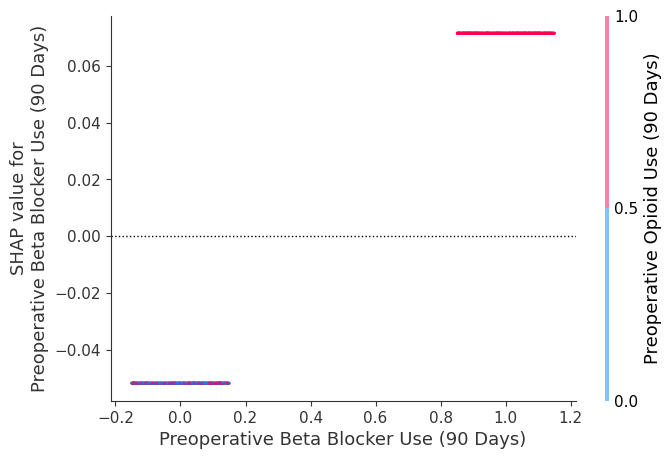

<Figure size 640x480 with 0 Axes>

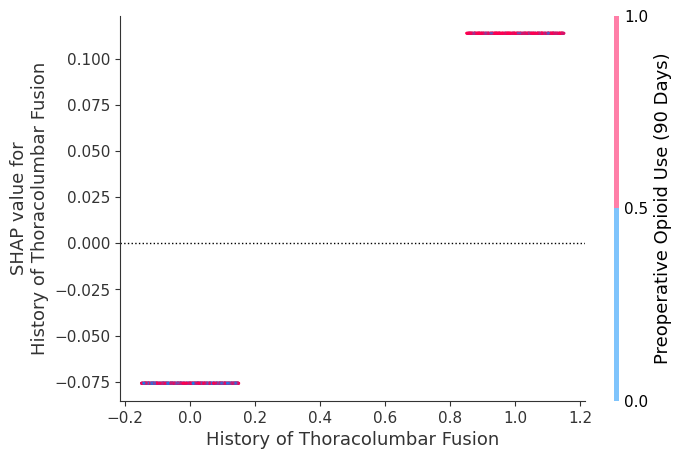

<Figure size 640x480 with 0 Axes>

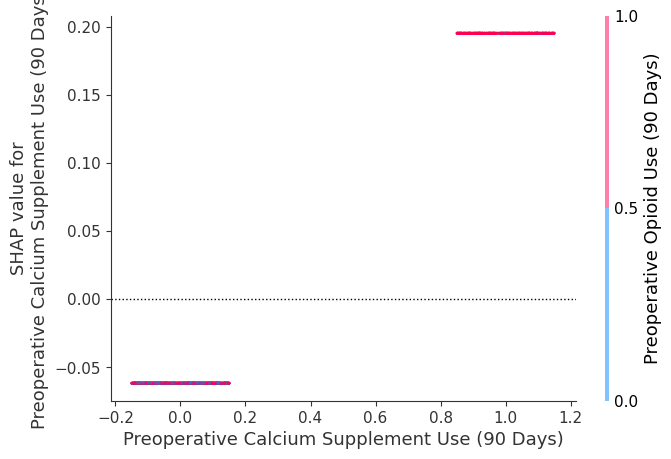

<Figure size 640x480 with 0 Axes>

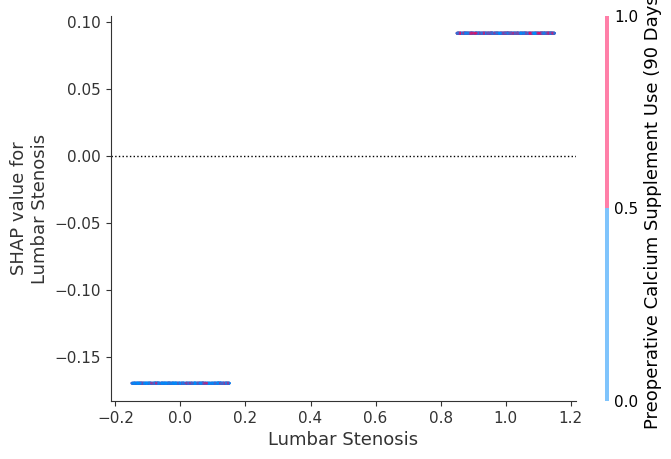

<Figure size 640x480 with 0 Axes>

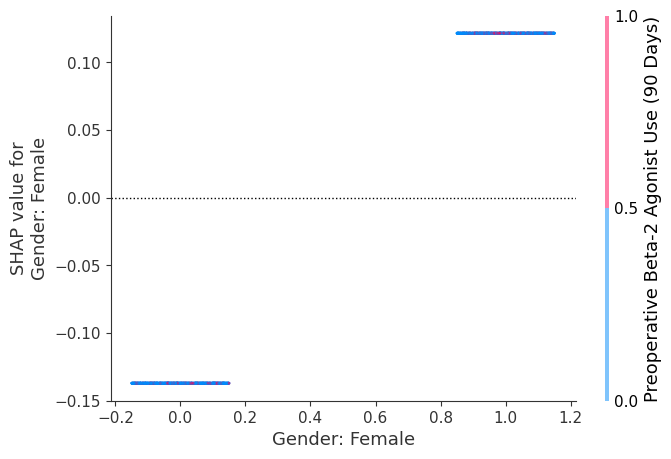

<Figure size 640x480 with 0 Axes>

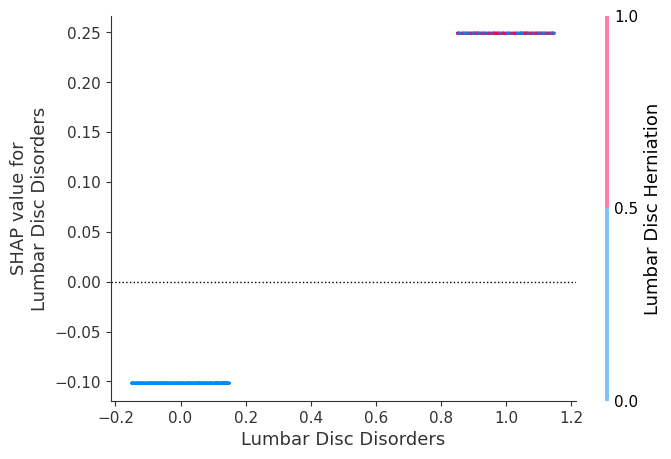

<Figure size 640x480 with 0 Axes>

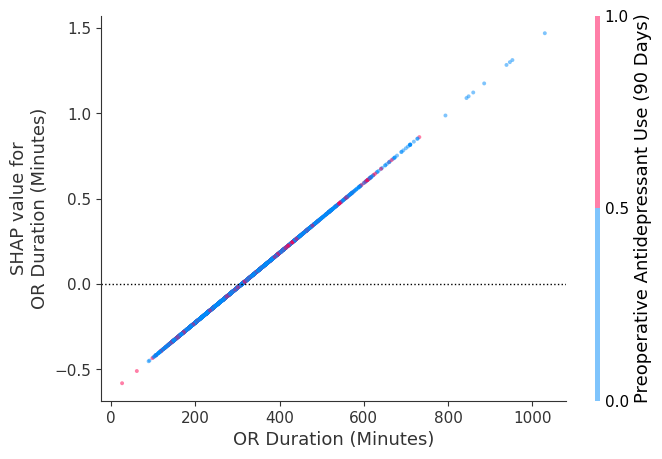

<Figure size 640x480 with 0 Axes>

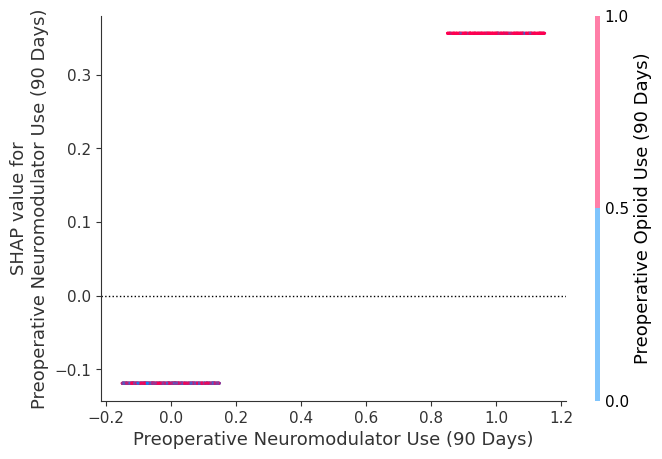

<Figure size 640x480 with 0 Axes>

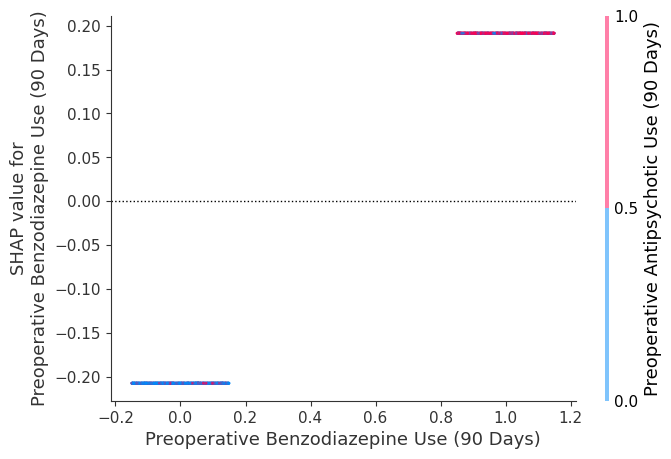

<Figure size 640x480 with 0 Axes>

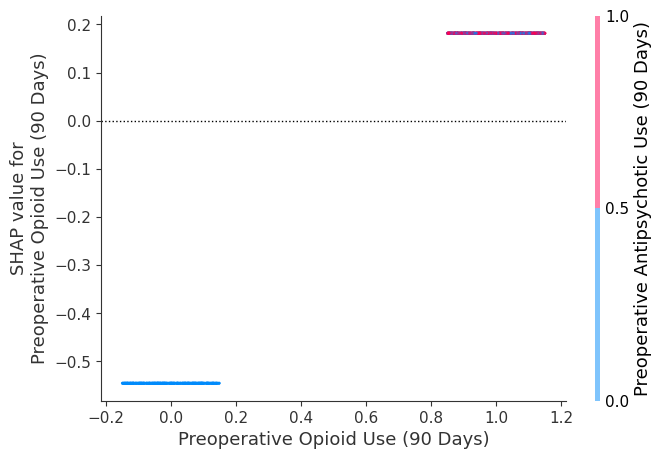

In [100]:

os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence', exist_ok=True)

for i in range(len(top_10_features)):
        column_label = top_10_columnNames[i]
        column_to_plot = top_10_features[i]
        if len(x_train_display_with_features[column_to_plot].unique()) < 5:
                jitter = 0.2
                dotsize = 4
                print(f"Jittering for {column_to_plot}")
                if FullDataset_model == "ENet":
                        print("ENET MODEL")
                        jitter = 0.3
        else: 
                jitter = 0
                dotsize = 8
        print(column_to_plot)
        print(x_train_display_with_features[column_to_plot].dtype)
        plt.figure()
        shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False, x_jitter=jitter)
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)        
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                                bbox_inches='tight', dpi=300)

Jittering for Preoperative Beta Blocker Use (90 Days)
Preoperative Beta Blocker Use (90 Days)
Int64
Jittering for History of Thoracolumbar Fusion
History of Thoracolumbar Fusion
Int64
Jittering for Preoperative Calcium Supplement Use (90 Days)
Preoperative Calcium Supplement Use (90 Days)
Int64
Jittering for Lumbar Stenosis
Lumbar Stenosis
Int64
Jittering for Gender: Female
Gender: Female
Int64
Jittering for Lumbar Disc Disorders
Lumbar Disc Disorders
Int64
OR Duration (Minutes)
Int64
Jittering for Preoperative Neuromodulator Use (90 Days)
Preoperative Neuromodulator Use (90 Days)
Int64
Jittering for Preoperative Benzodiazepine Use (90 Days)
Preoperative Benzodiazepine Use (90 Days)
Int64
Jittering for Preoperative Opioid Use (90 Days)
Preoperative Opioid Use (90 Days)
Int64


<Figure size 640x480 with 0 Axes>

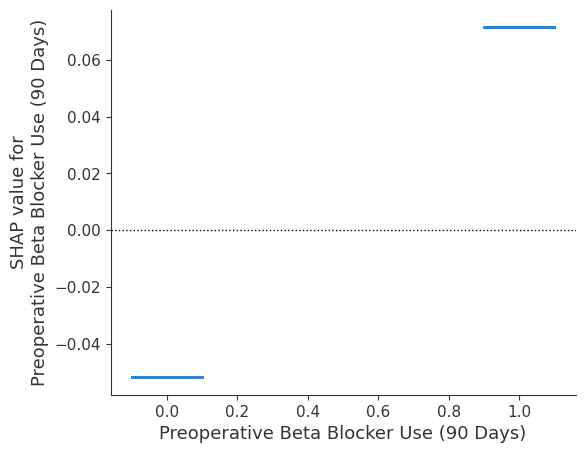

<Figure size 640x480 with 0 Axes>

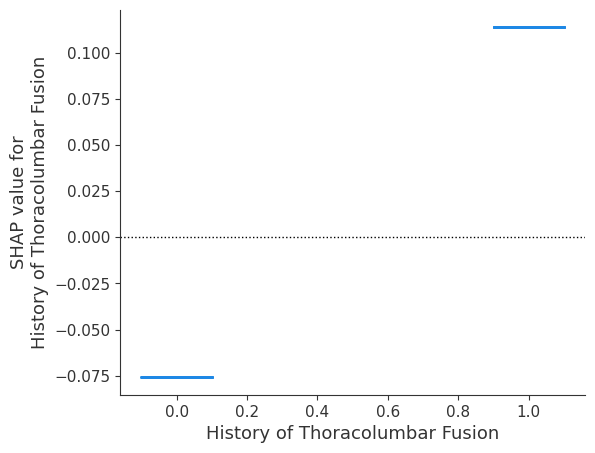

<Figure size 640x480 with 0 Axes>

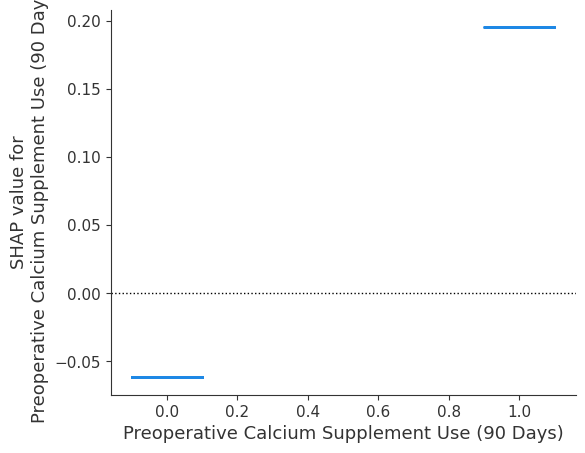

<Figure size 640x480 with 0 Axes>

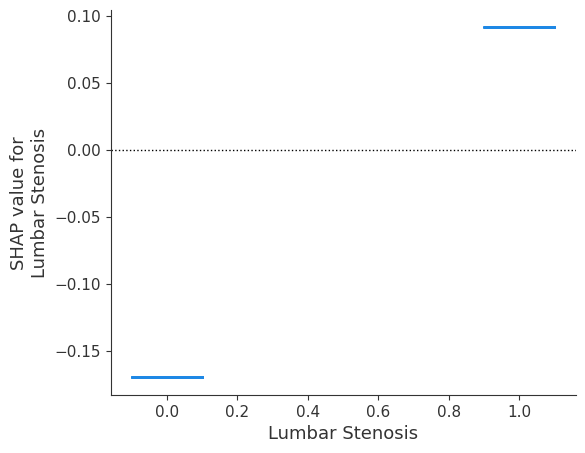

<Figure size 640x480 with 0 Axes>

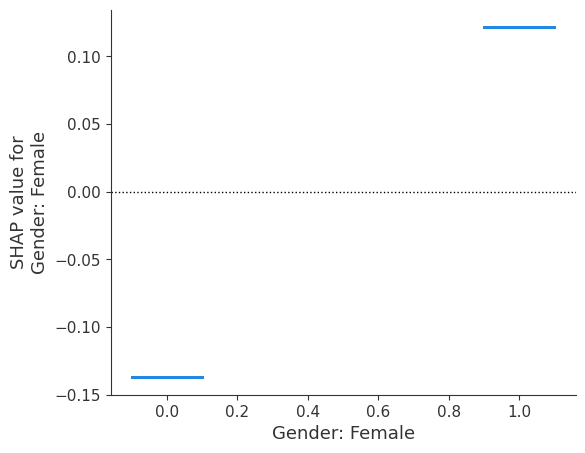

<Figure size 640x480 with 0 Axes>

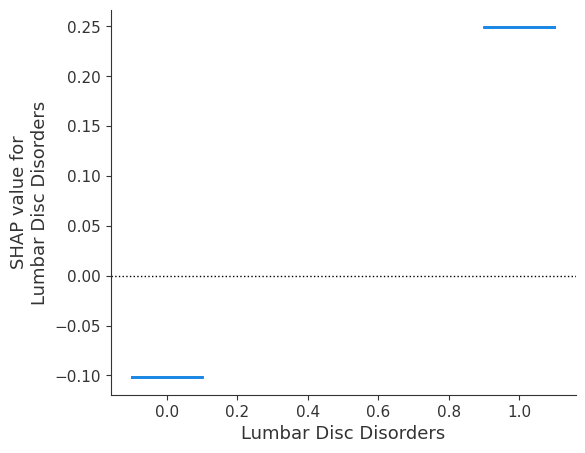

<Figure size 640x480 with 0 Axes>

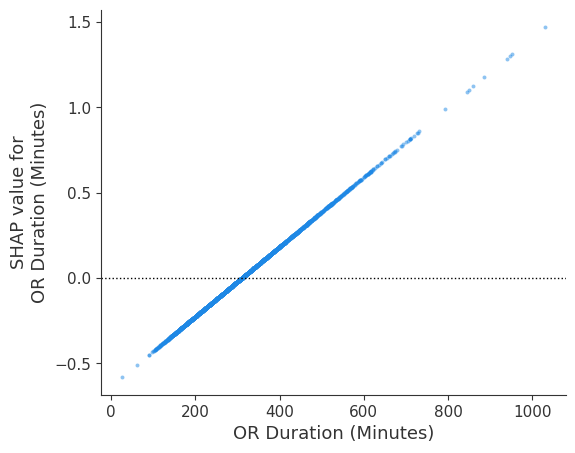

<Figure size 640x480 with 0 Axes>

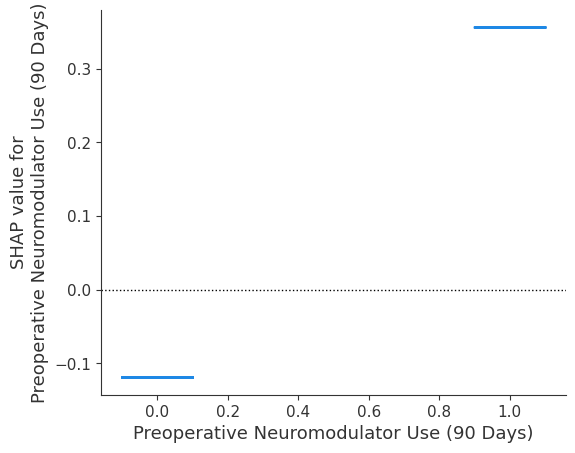

<Figure size 640x480 with 0 Axes>

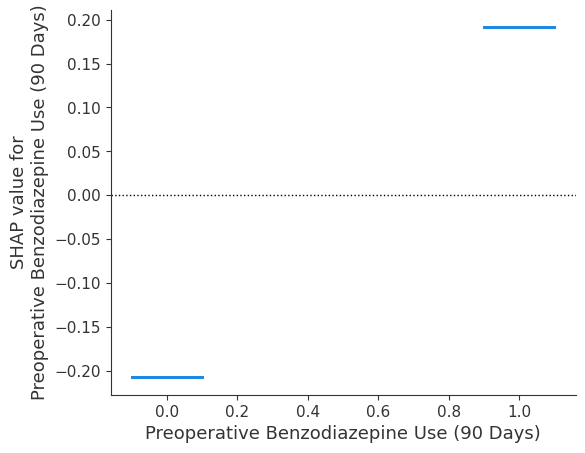

<Figure size 640x480 with 0 Axes>

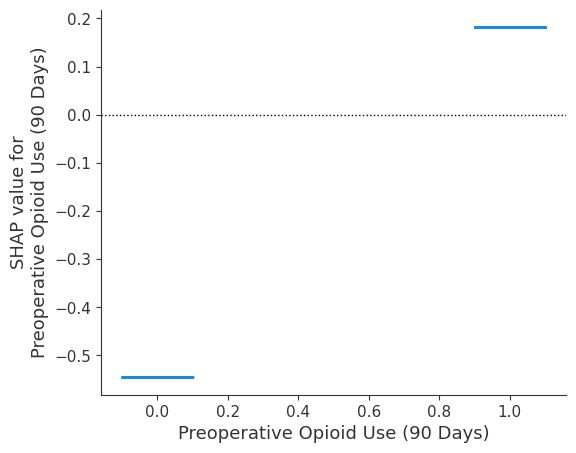

In [91]:
# Top 10 nocolor
os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence_noColor', exist_ok=True)

for i in range(len(top_10_features)):
        column_label = top_10_columnNames[i]
        column_to_plot = top_10_features[i]
        if len(x_train_display_with_features[column_to_plot].unique()) < 5:
                jitter = 0.2
                dotsize = 4
                print(f"Jittering for {column_to_plot}")
        else: 
                jitter = 0
                dotsize = 8
        print(column_to_plot)
        print(x_train_display_with_features[column_to_plot].dtype)
        plt.figure()
        shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False, x_jitter=jitter, interaction_index=None)
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)        
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence_noColor/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                                bbox_inches='tight', dpi=300)

###### Numerical Ones

<Figure size 640x480 with 0 Axes>

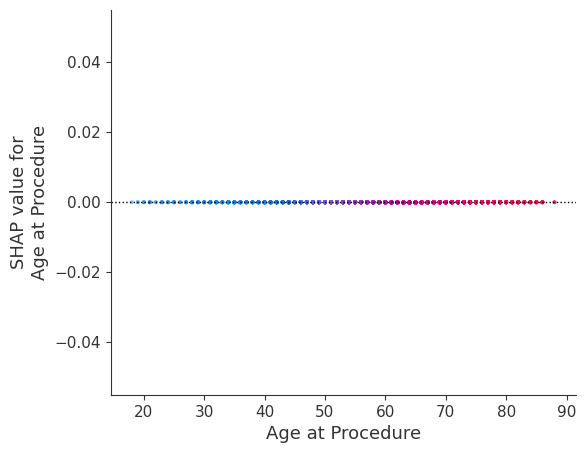

<Figure size 640x480 with 0 Axes>

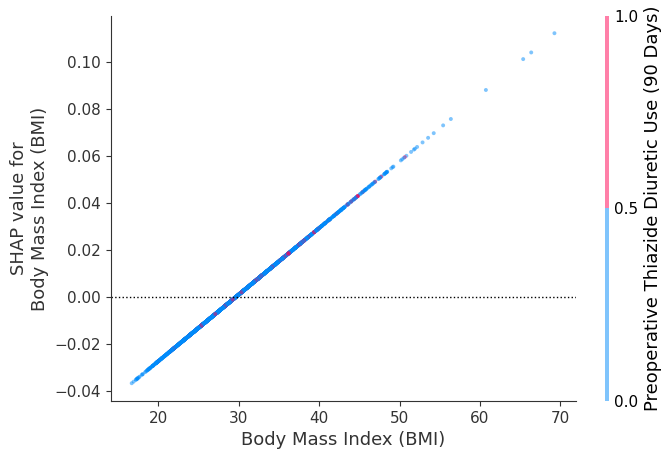

<Figure size 640x480 with 0 Axes>

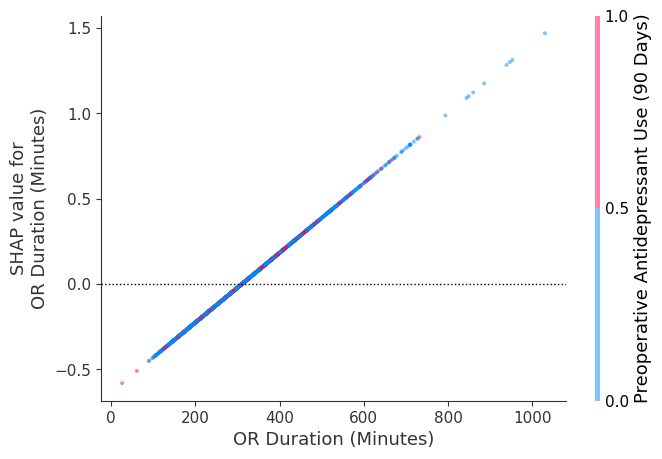

In [101]:


columns_to_plot = ["Age at Procedure", "Body Mass Index (BMI)", "OR Duration (Minutes)"]
column_labels = ["age", "bmi", "ORdur"]

for i in range(len(columns_to_plot)):
    column_label = column_labels[i]
    column_to_plot = columns_to_plot[i]
    plt.figure()
    shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=8, show=False)
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                bbox_inches='tight', 
                dpi=300)



###### Additional Specific Ones

<Figure size 640x480 with 0 Axes>

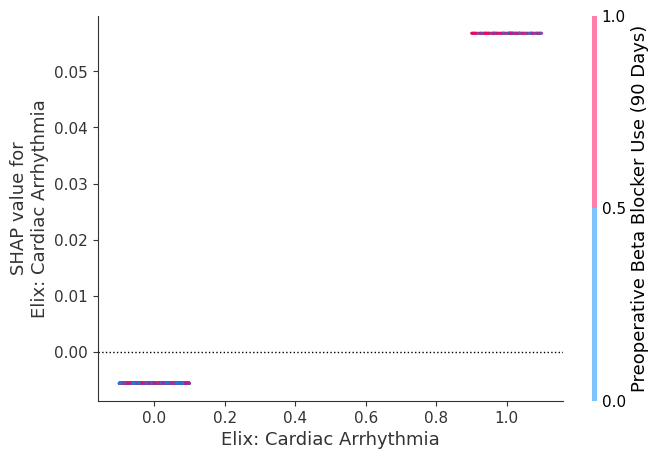

<Figure size 640x480 with 0 Axes>

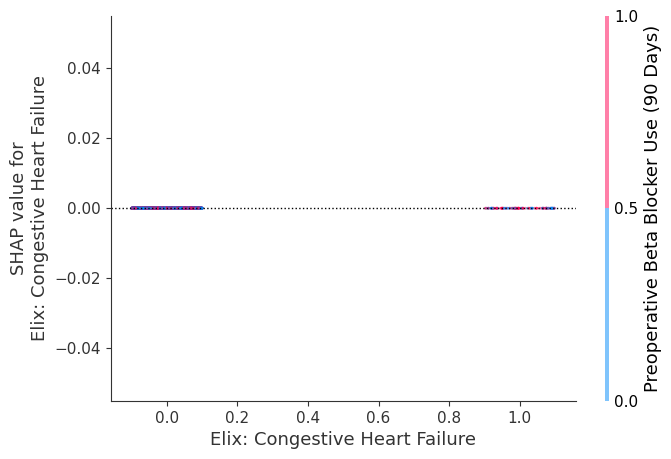

<Figure size 640x480 with 0 Axes>

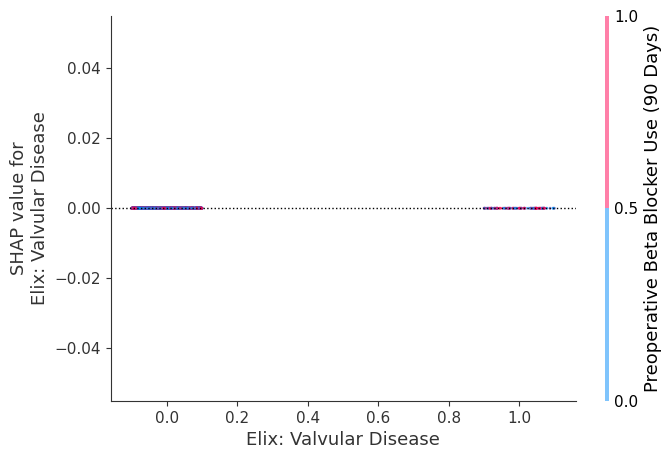

<Figure size 640x480 with 0 Axes>

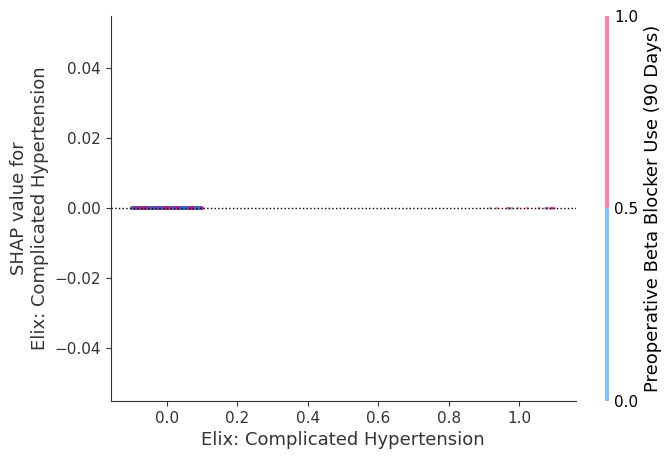

<Figure size 640x480 with 0 Axes>

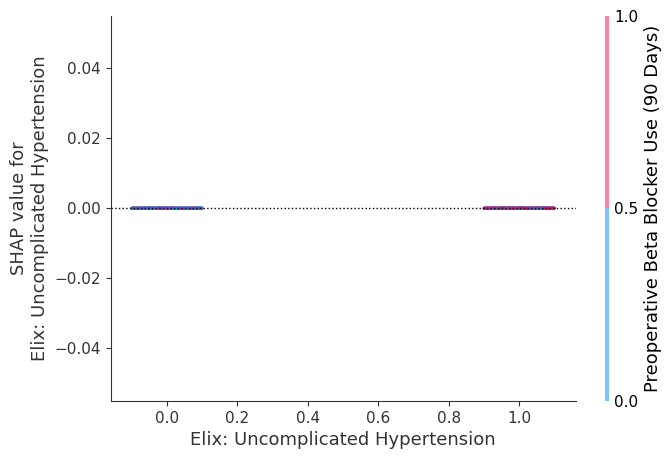

In [102]:
# Fusion Beta Blocker, color cardiac
if procedure_of_interest == "Fusion":

    #make directory for these
    os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta', exist_ok=True)
    cardiac_comorbidities = {"Elix: Cardiac Arrhythmia": "arrythmia", 
                            "Elix: Congestive Heart Failure": "CHF", 
                            "Elix: Valvular Disease": "Valvular_Disease",
                            "Elix: Complicated Hypertension": "HTN_Compl", 
                            "Elix: Uncomplicated Hypertension": "HTN_Uncompl"
    }
    jitter = 0.2
    dotsize = 4

    for (key, value) in cardiac_comorbidities.items():
        plt.figure()
        shap.dependence_plot(key, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False,
                            interaction_index = "Preoperative Beta Blocker Use (90 Days)", x_jitter = jitter)
        # Add horizontal dotted line at y=0
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta/shap_dependence_{value}_{feature_perturbation_version}.png', 
                    bbox_inches='tight', 
                    dpi=300)

In [103]:
cardiac_comorbidities = ["elix_cardiac_arrhythmia", "elix_congestive_heart_failure", "elix_valvular_disease", "elix_hypertension_complicated", "elix_hypertension_uncomplicated"]
x_train_cardiac = x_train.copy()
x_train_cardiac['cardiac_comorbidities'] = x_train_cardiac[cardiac_comorbidities].any(axis=1).astype("Int64")

# Create the contingency table with descriptive labels
beta_blocker_cardiac_contingency = pd.crosstab(
    x_train_cardiac['cardiac_comorbidities'], 
    x_train_cardiac["preop_med_90days_beta_blocker"],
    margins=True,  # This adds row and column totals
    margins_name='Total'
)

# Rename the index and columns for clarity
beta_blocker_cardiac_contingency.index = ['No Cardiac Disease', 'Has Cardiac Disease', 'Total']
beta_blocker_cardiac_contingency.columns = ['No Beta Blocker', 'On Beta Blocker', 'Total']

# Optional: Add a title
print("Contingency Table: Cardiac Disease vs Beta Blocker Use")
print(beta_blocker_cardiac_contingency)
if not os.path.exists(f"{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta"):
        os.makedirs(f"{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta")
beta_blocker_cardiac_contingency.to_csv(f"{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta/beta_blocker_cardiac_contingency.csv")


Contingency Table: Cardiac Disease vs Beta Blocker Use
                     No Beta Blocker  On Beta Blocker  Total
No Cardiac Disease               798              401   1199
Has Cardiac Disease              712              979   1691
Total                           1510             1380   2890


In [105]:
from scipy.stats import chi2_contingency
table_no_margins = beta_blocker_cardiac_contingency.iloc[:-1,:-1]
print(table_no_margins)
chi2, p_value, dof, expected = chi2_contingency(table_no_margins)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

                     No Beta Blocker  On Beta Blocker
No Cardiac Disease               798              401
Has Cardiac Disease              712              979
Chi-square statistic: 167.12209866494914
P-value: 3.146006394291046e-38
Degrees of freedom: 1
Expected frequencies: [[626.46712803 572.53287197]
 [883.53287197 807.46712803]]


#### Explainer Dashboard

##### Setup Explainer

In [61]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard


In [ ]:
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/trainingdata.pkl', 'rb') as g:
    training_data = pickle.load(g)

print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)

#unpickle
print(f"Unpickling from {FullDataset_model}, {procedure_of_interest}")
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled
x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std = training_data



In [ ]:
#Make and set shaps for explainer

dashboardExplainer = ClassifierExplainer(model=RF_cvmodel.best_estimator_, X=x_train, y=y_train, shap='tree', model_output='raw',
                                         target='1_year_ltc_postlaminectomy_syndrome', index_name="PtIndex")
dashboardExplainer.set_shap_values([-0.5, 0.5], [-full_dataset_shaps, full_dataset_shaps])

explainerLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/explainer.joblib'
dashboardExplainer.dump(explainerLocation)

In [ ]:
print(numeric_features)

##### Dashboard Run

In [ ]:
explainerLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/explainer.joblib'

explainer =  ClassifierExplainer.from_file(explainerLocation)
dashboard = ExplainerDashboard(
    explainer,
    tabs=['whatif'],  # Show only the What-If tab
    title="What-If Analysis Dashboard"
)
# Save the dashboard to a pickle file




In [ ]:
mainLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/'
dashboard.to_yaml(mainLocation+"dashboard.yaml", explainerfile="explainer.joblib" , dump_explainer=True)

In [ ]:
db = ExplainerDashboard.from_config(mainLocation+"explainer.joblib", mainLocation+"dashboard.yaml")
app = db.flask_server()

In [ ]:
import ngrok
# Expose local port using ngrok
public_url = ngrok.connect(805)  # Expose port 8050
print(f"Dashboard is live at: {public_url}")

# Run the dashboard
dashboard.run(port=805)

# Extra

In [ ]:
## Do all repetitions

for rep in repetitions:
    preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
    for i, (train_index, test_index) in enumerate(skf.split(dum_df, y)):
        # Create all the different train_test splits
        x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
        x_test_features_long, n_features, x_cols, x_train_std, x_test_std = set_train_test(dum_df= dum_df, y=y, train_index=train_index, test_index=test_index, rep=rep, preprocessor=preprocessor)

        for model in model_set:
            
            '''
            print(procedure)
            print(feature)
            print(outcome)
            print(rep)
            print(i)
            
            print(model)
            print(time.strftime('%X %x %Z'))
            '''
            if model == "ASA":
                asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)

            elif model == "ASA_categorical":
                y_pred, y_prob_vec_two = ASA_categorical_model(x_test=x_test)
                print(y_prob_vec_two)
                        
            elif model == "ENet":
                ENet_model_fitted, y_pred, y_prob_vec, shap_values = ENet_model(outcome, preprocessor, x_train, y_train,
                                                                                x_test, x_train_std, x_test_std, rep)    
            elif model == "XGBoost":
                XGBoost_model_fitted, y_pred, y_prob_vec, shap_values = XGBoost_model(outcome, preprocessor, x_train,
                                                                              y_train, x_test, x_train_std, x_test_std,
                                                                              rep)
            
            elif model == "RF": 
                
                   

        

    



In [ ]:
feature

In [ ]:
feature_results_output = pd.concat(feature_results, ignore_index = True)
feature_results_output.to_csv("thumb_arthro_features_3_11_23_partial.csv")

In [ ]:
#print(len(np.repeat(row, len(x_cols)))
print(len(shap_values_row))
print(len(temp_feature_names))

In [ ]:
print(all_results)

In [ ]:
individual_features_shap.to_csv("tester_shap.csv")

In [ ]:
    output_file_results.to_csv(file_name_results)
    
    
    feature_file_results = pd.concat(feature_results)
    feature_file_results = feature_file_results[feature_file_results['Procedure'] == procedure]
    feature_file_results.to_csv(file_name_features) 

In [ ]:
auc_plot_results.to_csv("auc_results_health_util_11_7_22.csv")    

In [ ]:
print(output_file_results)
np.median(output_file_results['MAE'])

In [ ]:
print(shap_features_row)

#shap_features_row.to_csv("NN_feature_test.csv")

summarized_features_shap = shap_features_row.groupby(['Feature_Name']).agg(
    Feature_Mean_Abs = ('Feature_Value_Abs','mean'),   
    Feature_Mean_Real = ('Feature_Value_Real','mean') 
).reset_index()

print(summarized_features_shap)
print()

In [ ]:
pip install joblib==1.1.0 --user

In [ ]:
#print(feature_results)
#print(all_results)
#feature_results.to_csv("feature_test_1_30_21.csv")
partial_output_results = pd.concat(all_results)
partial_output_features = pd.concat(feature_results)
partial_output_results.to_csv("partial_acdf_results_5_31_22.csv")
partial_output_features.to_csv("partial_acdf_features_5_31_22.csv")
#hyperparam_results.to_csv("all_results_acdf_cbc_bmp_hyperparam_lasso_brf_xgb_2_6_22_updated.csv")

print(feature_results)

In [ ]:
partial_output_file_results = pd.concat(all_results)
partial_output_file_results = partial_output_file_results[partial_output_file_results['Procedure'] == "PLF"]
partial_output_file_results.to_csv("partial_plf_results_5_31_22.csv")
    
    
partial_feature_file_results = pd.concat(feature_results)
partial_feature_file_results = partial_feature_file_results[partial_feature_file_results['Procedure'] == "PLF"]
partial_feature_file_results.to_csv("partial_plf_features_5_31_22.csv")   

In [ ]:
print(n_features)

In [ ]:
print(outcome)
print(procedure)
print(feature)

In [ ]:
summarized_results = all_results.groupby(['Outcome', 'Features', 'Model']).agg(
    WF1_Mean = ('W_F1','mean'),
    WF1_SD = ('W_F1', 'std'),
    AUC_Mean = ('AUC', 'mean'),
    AUC_SD = ('AUC', 'std'),
    Acc_Mean = ('Accuracy', 'mean'),
    Acc_SD = ('Accuracy', 'std'),
    BAcc_Mean = ('Balanced_Accuracy', 'mean'),
    BAcc_SD = ('Balanced_Accuracy', 'std'),
    Log_Loss_Mean = ('Log-Loss', 'mean'),
    Log_Loss_SD = ('Log-Loss', 'std'),
    Precision_Neg_Mean = ('Precision_Neg', 'mean'),
    Precision_Neg_SD = ('Precision_Neg', 'std'),
    Recall_Neg_Mean = ('Recall_Neg', 'mean'),
    Recall_Neg_SD = ('Recall_Neg', 'std'),
    Precision_Pos_Mean = ('Precision_Pos', 'mean'),
    Precision_Pos_SD = ('Precision_Pos', 'std'),
    Recall_Pos_Mean = ('Recall_Pos', 'mean'),
    Recall_Pos_SD = ('Recall_Pos', 'std'),
    n_Mean = ('n', 'mean'),
    n_SD = ('n', 'std'),
    label_n_Mean = ('label_n', 'mean'),
    label_n_SD = ('label_n', 'std')
    
    
).reset_index()

summarized_results.to_csv("wnd_dehis_summarized_lasso_brf_xgb_2_6_22_updated.csv")

print(summarized_results)

In [ ]:
print(feature_coef)
print(feature_coef_real)

In [ ]:
#feature_dat = pd.read_csv(r"Results/LASSO/pre_op_features_2_1_22.csv", sep=',')
feature_dat = pd.read_csv(r"wnd_dehis_features_lasso_brf_xgb_2_3_22_updated.csv", sep=',')


feature_dat['Feature_Value_Real'] = feature_dat['Feature_Value_Real'].str.strip('[]').astype(float) # uncomment and run this with lasso

summarized_features = feature_dat.groupby(['Outcome', 'Model', 'Feature_Name']).agg(
    Feature_Value_Mean = ('Feature_Value_Real', 'mean'),
    Feature_Value_SD = ('Feature_Value_Real', 'std'),
    
).reset_index()

summarized_features.to_csv("wnd_dehiscence_xgb_features_summarized_2_3_22_updated.csv")